<span style="color:blue;font-weight:bold;font-size:28px">Downloading and Structuring Historical ETF Data</span>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path
import os
from dateutil.relativedelta import relativedelta

# Set random seed and plot style
np.random.seed(233)
plt.style.use('fivethirtyeight')

# Define ETF list
etfs = ['IAU', 'LIT', 'QQQ', 'VOX', 'XLB', 'XLE', 'XLF', 'XLI', 'XLP', 'XLV', 'XLY']


# Function to download daily data
def download_data(etf_list, years_backward=10):
    # Set end_date to the last day of the previous month
    today = datetime.today()
    end_date = (today.replace(day=1) - relativedelta(days=1))  

    # Set start_date to 10 years before end_date
    start_date = (end_date - relativedelta(years=years_backward))  

    # Format dates as strings
    end_date_str = end_date.strftime('%Y-%m-%d')
    start_date_str = start_date.strftime('%Y-%m-%d')
    
    print(f"Data will be downloaded from {start_date_str} to {end_date_str}...")

    # Download data using yfinance
    data = yf.download(etf_list, start=start_date_str, end=end_date_str, interval='1d')['Adj Close']
    return data

# Download daily Adjusted Close price data
etf_data = download_data(etfs)

# Define base output directory
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

# Step 1: Create folders for each ETF and classify data by year
# Step 1: Create folders for each ETF and classify data by year
for etf in etfs:
    # Create ETF folder
    etf_dir = output_dir / etf
    etf_dir.mkdir(exist_ok=True)  # Ensure ETF folder exists
    
    # Extract data for the current ETF
    data = etf_data[[etf]].dropna().reset_index().sort_values(by='Date')
    data['Year'] = data['Date'].dt.year  # Add a Year column
    
    # Step 2: Group data by year and save into yearly folders
    for year, year_data in data.groupby('Year'):
        year_dir = etf_dir / str(year)  # Path to yearly folder
        year_dir.mkdir(exist_ok=True)  # Ensure year folder exists
        
        # Save the yearly data to a CSV file
        file_path = year_dir / f"{etf}_{year}_daily_data.csv"
        year_data[['Date', etf]].to_csv(file_path, index=False)
    
    # Print completion message for each ETF
    print(f"All yearly data for {etf} saved in {etf_dir}")

Data will be downloaded from 2014-11-30 to 2024-11-30...
[*********************100%***********************]  11 of 11 completed
All yearly data for IAU saved in output/IAU
All yearly data for LIT saved in output/LIT
All yearly data for QQQ saved in output/QQQ
All yearly data for VOX saved in output/VOX
All yearly data for XLB saved in output/XLB
All yearly data for XLE saved in output/XLE
All yearly data for XLF saved in output/XLF
All yearly data for XLI saved in output/XLI
All yearly data for XLP saved in output/XLP
All yearly data for XLV saved in output/XLV
All yearly data for XLY saved in output/XLY


<span style="color:blue;font-weight:bold;font-size:22px">Exploratory Data Analysis (EDA)</span>

<span style="color:blue;font-weight:bold;font-size:18px">Visualizing ETF Price Trends: 1.1 in 2020 and 2022</span>

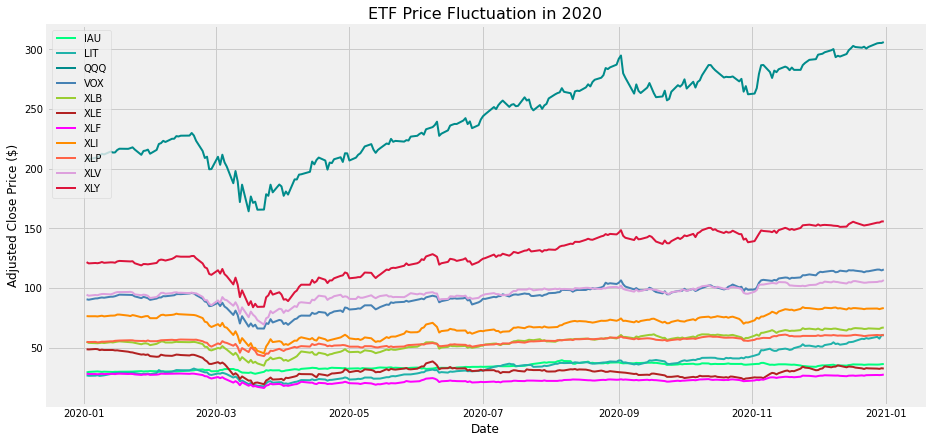

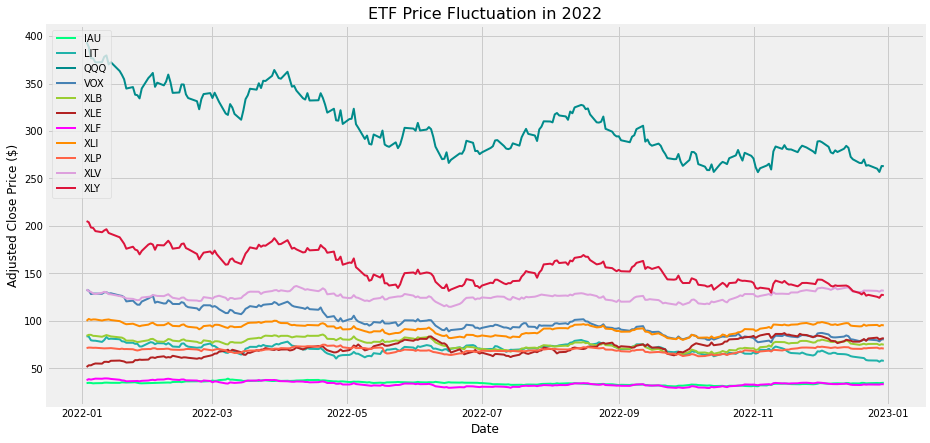

In [2]:
# List of ETFs
etfs = ['IAU', 'LIT', 'QQQ', 'VOX', 'XLB', 'XLE', 'XLF', 'XLI', 'XLP', 'XLV', 'XLY']

# Colors for plotting
colors = ['springgreen', 'lightseagreen', 'darkcyan',
          'steelblue', 'yellowgreen', 'firebrick',
          'fuchsia', 'darkorange', 'tomato', 'plum', 'crimson']

# Define your output directory where CSV files are stored
output_dir = Path("output")

def plot_etf_prices(year, etf_list=etfs):

    combined_df = pd.DataFrame()

    for etf in etf_list:
        # Path to the CSV file for this ETF and year
        csv_file = output_dir / etf / str(year) / f"{etf}_{year}_daily_data.csv"

        if not csv_file.exists():
            print(f"[Warning] File not found for {etf} in {year}: {csv_file}")
            continue

        df = pd.read_csv(csv_file, parse_dates=['Date'])

        # Make 'Date' the index
        df.set_index('Date', inplace=True)

        # If the combined_df is empty, initialize it; otherwise join
        if combined_df.empty:
            combined_df = df[[etf]].copy()
        else:
            combined_df = combined_df.join(df[[etf]], how='outer')

    # Plot
    plt.figure(figsize=(14, 7))
    for etf_col, color in zip(combined_df.columns, colors):
        plt.plot(combined_df.index, combined_df[etf_col], label=etf_col, color=color, lw=2)

    plt.title(f"ETF Price Fluctuation in {year}", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price ($)")
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)
    plt.show()

# Example usage
plot_etf_prices(2020)
plot_etf_prices(2022)

<span style="color:blue;font-weight:bold;font-size:18px">1.2 Price Trends Over the Last 10 Years (Dynamic)</span>

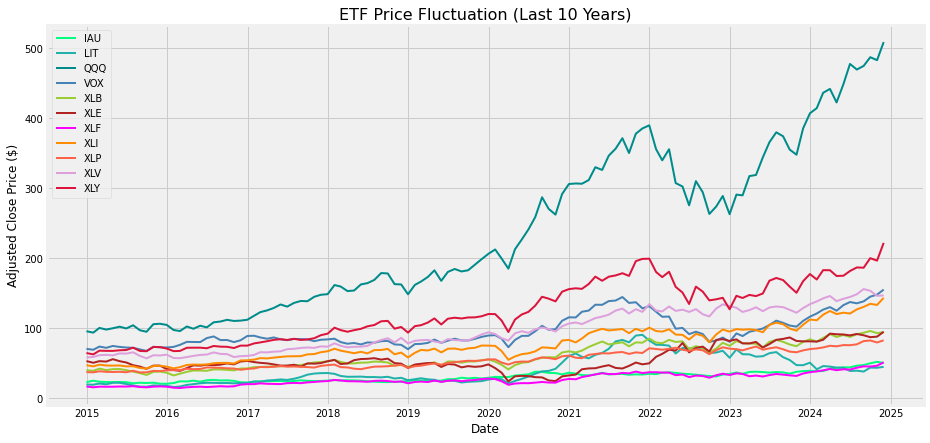

In [3]:
def plot_etf_10y(etf_list=etfs, start_year=2013, end_year=2024):
   
    combined_10y_df = pd.DataFrame()

    for etf in etf_list:
        # Accumulate daily data for this ETF across multiple years
        etf_all_years = pd.DataFrame()

        for year in range(start_year, end_year + 1):
            csv_file = output_dir / etf / str(year) / f"{etf}_{year}_daily_data.csv"

            if not csv_file.exists():
                # If the file doesn't exist for this year, skip it
                continue

            df = pd.read_csv(csv_file, parse_dates=['Date']).dropna()
            df.set_index('Date', inplace=True)

            # Concatenate all data for the ETF
            etf_all_years = pd.concat([etf_all_years, df[[etf]]])

        # Merge into the overall combined DataFrame
        if combined_10y_df.empty:
            combined_10y_df = etf_all_years
        else:
            combined_10y_df = combined_10y_df.join(etf_all_years, how='outer')

    # If you want monthly data, resample to the last trading day of the month
    monthly_10y_df = combined_10y_df.resample('M').last()

    # Plot
    plt.figure(figsize=(14, 7))
    for etf_col, color in zip(monthly_10y_df.columns, colors):
        plt.plot(monthly_10y_df.index, monthly_10y_df[etf_col], label=etf_col, color=color, lw=2)

    plt.title("ETF Price Fluctuation (Last 10 Years)", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price ($)")
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)
    plt.show()

# Example usage (adjust the year range as needed)
plot_etf_10y(etfs, start_year=2013, end_year=2024)

<span style="color:blue;font-weight:bold;font-size:18px">2.Monthly and Log Return </span>

In [4]:
# Set Pandas display options to improve output format
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define base output directory
output_dir = Path("/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/output")
output_dir.mkdir(exist_ok=True)  # Ensure output directory exists

combined_returns = pd.DataFrame()
log_returns = pd.DataFrame()

# Loop through each ETF
for etf in etfs:
    etf_dir = output_dir / etf  # ETF folder path
    etf_dir.mkdir(exist_ok=True)  # Ensure ETF directory exists

    # Combine all yearly data for the current ETF
    combined_data = pd.DataFrame()
    for year_folder in etf_dir.iterdir():
        if year_folder.is_dir():  # Ensure it's a folder
            for file in year_folder.glob(f"{etf}_*_daily_data.csv"):
                yearly_data = pd.read_csv(file, parse_dates=['Date'])
                combined_data = pd.concat([combined_data, yearly_data], ignore_index=True)
    
    # Sort by Date and calculate monthly prices
    combined_data = combined_data.dropna().sort_values(by='Date').set_index('Date')
    assert isinstance(combined_data.index, pd.DatetimeIndex), "Index must be a DatetimeIndex for resampling"
    monthly_prices = combined_data[etf].resample('M').apply(lambda x: x.iloc[-1])  # Last trading day of each month

    # Calculate monthly returns
    monthly_return = monthly_prices.pct_change().dropna().rename(etf)
    combined_returns = pd.concat([combined_returns, monthly_return], axis=1)

    # Calculate log returns
    if (monthly_return < -1).any():
        raise ValueError(f"Negative return found in {etf}, cannot calculate log return for values <= -1")
    log_return = np.log(1 + monthly_return).rename(etf)
    log_returns = pd.concat([log_returns, log_return], axis=1)

# Ensure the index is a DatetimeIndex
if not isinstance(combined_returns.index, pd.DatetimeIndex):
    combined_returns.index = pd.to_datetime(combined_returns.index)

if not isinstance(log_returns.index, pd.DatetimeIndex):
    log_returns.index = pd.to_datetime(log_returns.index)

# Format values and remove time part from the index
combined_returns.index = combined_returns.index.strftime('%Y-%m-%d')
combined_returns = combined_returns.round(5)

log_returns.index = log_returns.index.strftime('%Y-%m-%d')
log_returns = log_returns.round(5)

# Save as CSV
combined_returns.to_csv('combined_monthly_returns.csv', index=True)
log_returns.to_csv('combined_monthly_logreturns.csv', index=True)

# Print first 10 rows of both DataFrames for verification
print(log_returns.head(10))

                IAU      LIT      QQQ      VOX      XLB      XLE      XLF      XLI      XLP      XLV      XLY
2015-01-31  0.08300 -0.01630 -0.02104 -0.01919 -0.01849 -0.04668 -0.07209 -0.03617 -0.00974  0.01293 -0.03039
2015-02-28 -0.05967  0.08404  0.06972  0.06408  0.07667  0.04491  0.05660  0.05213  0.04061  0.04198  0.08199
2015-03-31 -0.02245 -0.05435 -0.02387 -0.02468 -0.05029 -0.01162 -0.00618 -0.02579 -0.01962  0.00639 -0.00484
2015-04-30 -0.00087  0.10589  0.01904  0.03624  0.03307  0.06367  0.00083 -0.00251 -0.00762 -0.01096 -0.00053
2015-05-31  0.00610 -0.00319  0.02224 -0.01846  0.00376 -0.05328  0.01929  0.00323  0.00865  0.04406  0.01306
2015-06-30 -0.01488 -0.08164 -0.02515 -0.01200 -0.04030 -0.03546 -0.00462 -0.02691 -0.01851 -0.00393  0.00553
2015-07-31 -0.06937 -0.11097  0.04457 -0.00600 -0.05174 -0.08002  0.03348  0.00295  0.05537  0.02914  0.04774
2015-08-31  0.03711 -0.09240 -0.07069 -0.03186 -0.05802 -0.04345 -0.07322 -0.05555 -0.06148 -0.08300 -0.06755
2015-09-30

<span style="color:blue;font-weight:bold;font-size:18px">3.Histogram: Log Returns Distribution Analysis</span>

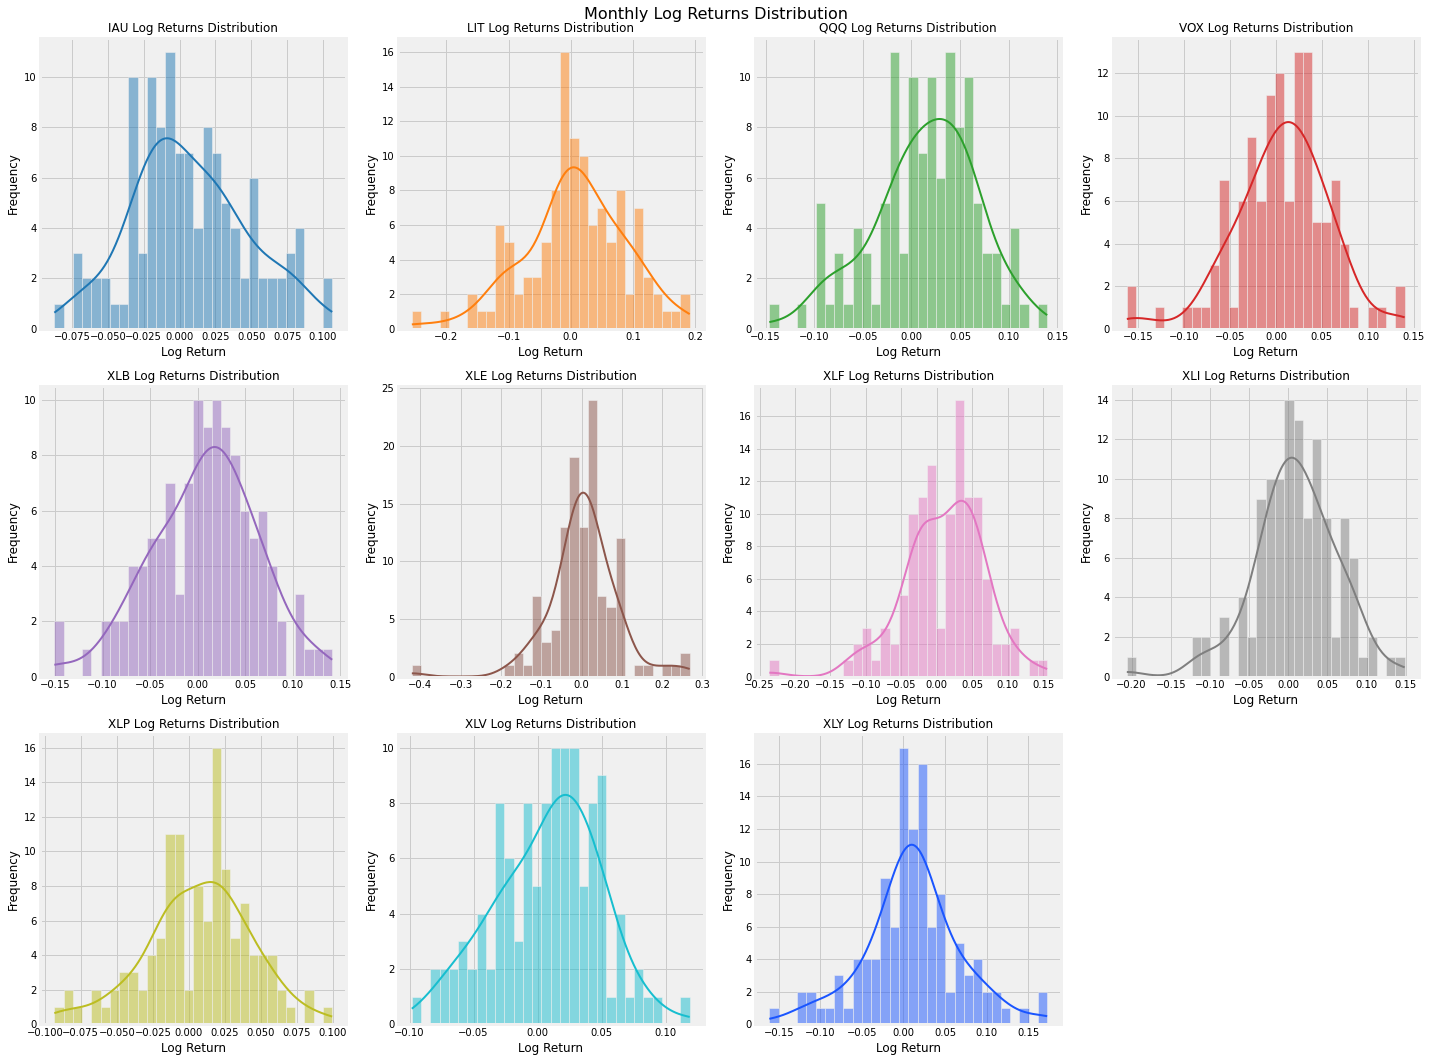

In [7]:
import math

n = len(log_returns.columns)
rows = math.ceil(n / 4)  # 4 columns per row

# Step 1: Load the log returns data
file_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
log_returns = pd.read_csv(file_path, index_col=0, parse_dates=True)  # Use 'Date' column as index

# Step 2: Define unique colors for each ETF
unique_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1a55FF'
]

# Step 3: Plot the log returns distribution for each ETF
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), tight_layout=True)
plt.suptitle("Monthly Log Returns Distribution", fontsize=16)

# Step 4: Loop through each ETF and plot its distribution
for i, etf in enumerate(log_returns.columns):  # Iterate through ETF names
    data = log_returns[etf].dropna()  # Drop NaN values for the current ETF
    ax = axes[i // 4, i % 4]  # Determine subplot position

    # Plot histogram and KDE curve
    sns.histplot(data, bins=30, kde=True, color=unique_colors[i], ax=ax, 
                 line_kws={"color": "black", "linewidth": 2})
    ax.set_title(f"{etf} Log Returns Distribution", fontsize=12)
    ax.set_xlabel("Log Return")
    ax.set_ylabel("Frequency")
# Remove unused subplots if ETF count < 12
if len(log_returns.columns) < 12:
    for j in range(len(log_returns.columns), 12):
        fig.delaxes(axes.flatten()[j])

plt.show()

1. **IAU (Gold ETF)**  
   - **Distribution Shape**: Slightly right-skewed, with a longer right tail.  
   - **Implication**: The skewness suggests occasional larger positive returns, but most returns are clustered around zero.  
   - **Range**: **-0.05 to 0.10**, indicating **low to moderate volatility**, which aligns with gold’s historical role as a stable asset.  
   - **Investment Insight**: Given its low volatility and occasional positive spikes, IAU is suitable for risk-averse investors seeking stability and a hedge against market downturns.

2. **LIT (Lithium ETF)**  
   - **Distribution Shape**: Near-normal with a slightly longer left tail.  
   - **Implication**: The distribution highlights occasional sharp negative returns, though overall returns are fairly symmetric.  
   - **Range**: **-0.2 to 0.2**, reflecting **high volatility**. Such large fluctuations are characteristic of emerging sectors like lithium.  
   - **Investment Insight**: LIT’s high volatility offers significant growth potential but comes with greater downside risk. It is best suited for investors with high risk tolerance and a long-term growth focus.

3. **QQQ (Nasdaq-100 ETF)**  
   - **Distribution Shape**: Left-skewed, with a noticeable longer left tail.  
   - **Implication**: The skewness indicates susceptibility to larger negative returns, particularly during tech-sector corrections.  
   - **Range**: **-0.15 to 0.15**, indicating **moderate to high volatility**, which aligns with its technology sector exposure.  
   - **Investment Insight**: QQQ provides strong upside potential but carries downside risk during market corrections. Investors should consider it for growth opportunities but maintain diversification to mitigate risk.

4. **VOX (Communication ETF)**  
   - **Distribution Shape**: Close to a normal distribution, with minimal skewness.  
   - **Implication**: The near-normal distribution suggests balanced risk-return behavior with fewer extreme outliers.  
   - **Range**: **-0.15 to 0.15**, reflecting **moderate volatility**, typical for the communication sector.  
   - **Investment Insight**: VOX offers stable returns with moderate volatility, making it a good option for investors seeking a balance between risk and reward.

5. **XLB (Materials ETF)**
   - **Distribution Shape**: Close to a normal distribution, with minimal skewness.
   - **Range**: **-0.15 to 0.15**, indicating moderate volatility influenced by industrial demand.
   - **Implication**: Stable return patterns make XLB a balanced option within the materials sector.
   - **Investment Insight**: Suitable for investors looking for stable growth with moderate risk.

6. **XLE (Energy ETF)**
   - **Distribution Shape**: Close to normal, with a slightly longer right tail.
   - **Range**: **-0.2 to 0.2**, reflecting the highest volatility among these ETFs.
   - **Implication**: Volatility driven by external shocks like oil price changes and geopolitical events.
   - **Investment Insight**: Best for risk-tolerant investors seeking high returns but prepared for market swings.

7. **XLF (Financials ETF)**
   - **Distribution Shape**: Displays a bimodal distribution, with two distinct peaks.
   - **Range**: **-0.2 to 0.1**, indicating high volatility, likely driven by macroeconomic factors.
   - **Implication**: Bimodal shape suggests multiple market influences or instability within the sector.
   - **Investment Insight**: Riskier and less predictable. Diversification is recommended to mitigate systemic risks.

8. **XLI (Industrials ETF)**
   - **Distribution Shape**: Close to a normal distribution, with minimal skewness.
   - **Range**: **-0.1 to 0.1**, showing the narrowest range and lowest volatility.
   - **Implication**: Stability in returns makes XLI less risky compared to other cyclical sectors.
   - **Investment Insight**: Ideal for conservative investors looking for predictable returns with minimal risk.

9. XLP (Consumer Staples ETF)**  
   - **Distribution Shape**: Near-normal with a slight skew to the right, indicating a longer right tail.  
   - **Implication**: The slight right skew suggests occasional larger positive returns, though most returns are   
     tightly clustered around zero.  
   - **Range**: **-0.10 to 0.10**, reflecting **low volatility**, typical of the consumer staples sector, which is 
     known for its defensive nature.  
   - **Investment Insight**: XLP's stability and low volatility make it suitable for risk-averse investors seeking 
     steady, predictable returns.  

10. XLV (Health Care ETF)**  
    - **Distribution Shape**: Near-normal with a slight skew to the right.  
    - **Implication**: The skewness suggests consistent performance with occasional higher positive returns, 
      aligning with the defensive and growth-oriented characteristics of the health care sector.  
    - **Range**: **-0.10 to 0.10**, indicating **low volatility** and stable returns.  
    - **Investment Insight**: XLV is a strong option for investors seeking stable growth with minimal risk, 
      particularly in uncertain economic conditions.  

11. XLY (Consumer Discretionary ETF)**  
    - **Distribution Shape**: Close to a perfect normal distribution, with minimal skewness and a symmetric shape.  
    - **Implication**: The symmetric distribution indicates balanced risk-return characteristics, with returns 
      evenly distributed on both sides of the mean.  
    - **Range**: **-0.15 to 0.15**, reflecting **moderate volatility**, common in the consumer discretionary 
      sector, which is sensitive to economic cycles.  
    - **Investment Insight**: XLY offers a balance of risk and reward, making it ideal for investors seeking 
      moderate growth potential during economic expansions.  

### **Skewness Explanation**  
- **Positive Skewness**: Indicates a longer right tail, where occasional large positive returns occur. This often implies higher upside potential but may also suggest increased risk for extreme returns.  
- **Negative Skewness**: Represents a longer left tail, implying susceptibility to larger negative returns.  
- **No Skewness (Normal Distribution)**: Suggests balanced risk-return behavior, where returns are evenly distributed around the mean.  
    

<span style="color:blue;font-weight:bold;font-size:18px">4.Skewness & Kurtosis </span>

=== Skewness & Kurtosis for Each ETF ===
     Skewness  Kurtosis
IAU    0.2455   -0.2137
LIT   -0.3248    0.4306
QQQ   -0.4150    0.1193
VOX   -0.4448    1.2651
XLB   -0.2718    0.1823
XLE   -0.5750    5.2266
XLF   -0.7326    2.1662
XLI   -0.5233    1.7552
XLP   -0.2882    0.3257
XLV   -0.2270   -0.1184
XLY   -0.0374    0.9876


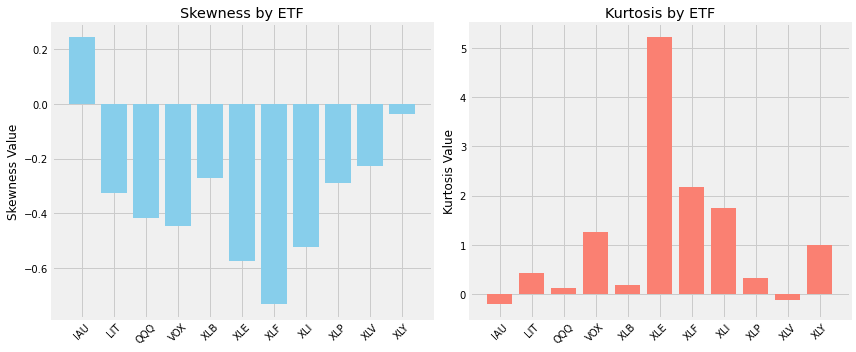

In [8]:
# Step 5: Calculate Skewness and Kurtosis for each ETF
skewness_values = log_returns.skew()
kurtosis_values = log_returns.kurt()

# Combine results into a DataFrame
stats_df = pd.DataFrame({
    "Skewness": skewness_values,
    "Kurtosis": kurtosis_values
})

# Step 6: Print the result or do further processing
print("=== Skewness & Kurtosis for Each ETF ===")
print(stats_df.round(4))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), tight_layout=True)

# Plot Skewness
axes[0].bar(stats_df.index, stats_df["Skewness"], color='skyblue')
axes[0].set_title("Skewness by ETF")
axes[0].set_ylabel("Skewness Value")
axes[0].tick_params(axis='x', rotation=45)

# Plot Kurtosis
axes[1].bar(stats_df.index, stats_df["Kurtosis"], color='salmon')
axes[1].set_title("Kurtosis by ETF")
axes[1].set_ylabel("Kurtosis Value")
axes[1].tick_params(axis='x', rotation=45)

plt.show()

## Skewness & Kurtosis Analysis

### Overview
We computed the Skewness and Kurtosis of each ETF’s monthly log returns and then visualized these statistics in bar charts. Comparing those bar charts to the individual return histograms confirms that both methods convey a consistent story about each ETF’s return distribution shape.

### Histogram vs. Bar Charts Consistency
1. **Skewness:**
   - **XLE (Energy)** shows a pronounced left tail in its histogram, which aligns with its highly negative skewness (approximately -0.5750).  
   - **IAU (Gold)** exhibits a slight right-tail bias in the histogram, matching its positive skewness (~0.2455).  
   - Most other ETFs (like QQQ, XLF, XLI) display negative skewness in the bar chart, which corresponds to the histograms leaning more to the left.

2. **Kurtosis:**
   - **XLE (Energy)** again stands out due to its very high kurtosis (5.2266), reflected in heavier tails and more extreme values visible in its histogram.  
   - **XLV (Healthcare)** has near-zero or slightly negative kurtosis, consistent with a relatively “normal-like” shape and fewer extreme outliers.  
   - **XLF (Financials)** shows moderately elevated kurtosis (2.1662), indicating heavier tails than a normal distribution, which aligns with the tail extensions in its histogram.


<span style="color:blue;font-weight:bold;font-size:18px">5.KS-test and QQ-plot</span>

In [9]:
from scipy.stats import kstest
import os

# Read log return data
file_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
log_returns = pd.read_csv(file_path, index_col=0)

# KS-test and save results to a DataFrame
ks_results = []
output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

# Perform KS-test
for ticker in log_returns.columns:
    data = log_returns[ticker].dropna()
   
    mean, std = data.mean(), data.std()
    test_stat = kstest(data, 'norm', args=(mean, std))  # 指定分布的均值和标准差
    ks_results.append({
        "ETF": ticker,
        "Statistic": round(test_stat.statistic, 5),
        "P-value": f"{test_stat.pvalue:.5e}",
        "Result": "Reject normality" if test_stat.pvalue < 0.05 else "Fail to reject normality"
    })
# Convert to DataFrame
ks_df = pd.DataFrame(ks_results)

# Save to CSV (Excel-readable format)
csv_path = os.path.join(output_folder, "ks_test_results.csv")
ks_df.to_csv(csv_path, index=False)

# Reload the CSV file and display the table
reloaded_df = pd.read_csv(csv_path)

# Display the reloaded table cleanly
print("\nKS-Test Results:")
display(reloaded_df)


KS-Test Results:


,ETF,Statistic,P-value,Result
0,IAU,0.06947,0.589434,Fail to reject normality
1,LIT,0.07957,0.416783,Fail to reject normality
2,QQQ,0.06697,0.635233,Fail to reject normality
3,VOX,0.06667,0.640703,Fail to reject normality
4,XLB,0.05673,0.817391,Fail to reject normality
5,XLE,0.10801,0.115563,Fail to reject normality
6,XLF,0.08471,0.341059,Fail to reject normality
7,XLI,0.07168,0.549583,Fail to reject normality
8,XLP,0.06477,0.675729,Fail to reject normality
9,XLV,0.06623,0.648850,Fail to reject normality


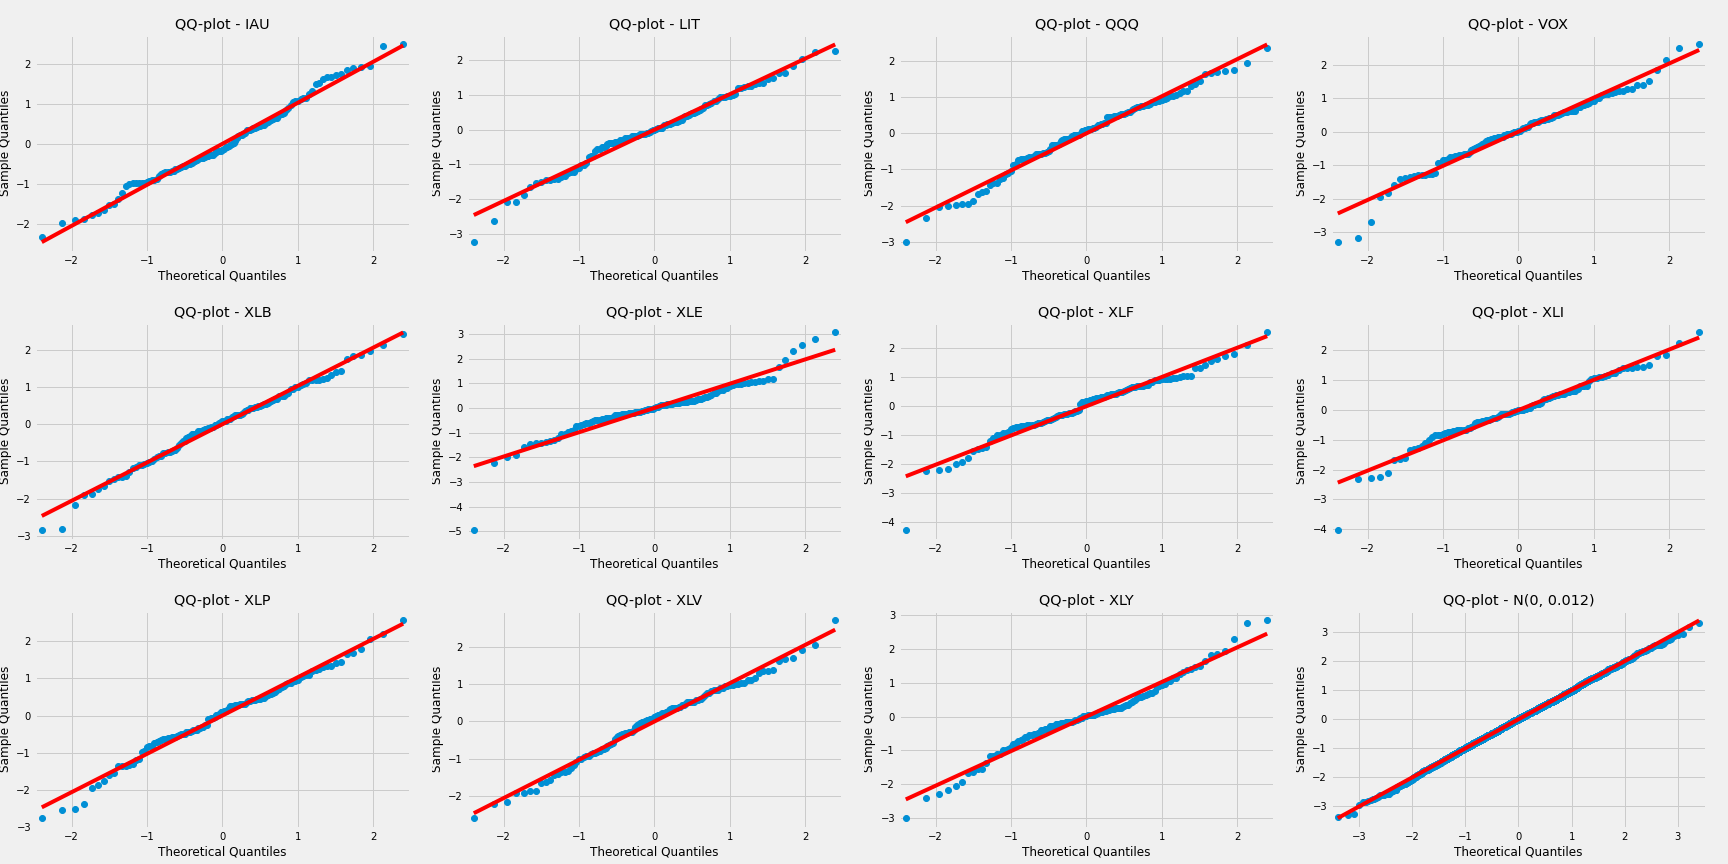

In [10]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from PIL import Image

for ticker in log_returns.columns:
    # Drop NaN values
    data = log_returns[ticker].dropna()
    
    # Generate QQ-plot
    fig = sm.qqplot(data, line='r', fit=True)
    plt.title(f"QQ-plot - {ticker}")
    plt.savefig(f"{output_folder}/qq-plot-{ticker}.png")
    plt.close()

# Generate a QQ-plot for standard normal distribution
normal_data = np.random.normal(0, 0.012, 3000)
fig = sm.qqplot(normal_data, line='r', fit=True)
plt.title("QQ-plot - N(0, 0.012)")
plt.savefig(f"{output_folder}/qq-plot-norm.png")
plt.close()

# Combine all QQ-plots into a single large image (4x3 grid)
png_set = [f"{output_folder}/qq-plot-{ticker}.png" for ticker in log_returns.columns] + [f"{output_folder}/qq-plot-norm.png"]
images = [Image.open(x) for x in png_set]

# Determine total image size
widths, heights = zip(*(i.size for i in images))
total_width = widths[0] * 4  # 4 columns
max_height = heights[0] * 3  # 3 rows

# Create a new blank image
new_image = Image.new('RGB', (total_width, max_height))

# Paste individual images onto the blank image
for i in range(len(images)):
    new_image.paste(images[i], ((i % 4) * widths[0], (i // 4) * heights[0]))

# Save and display the final combined image
final_image_path = f"{output_folder}/QQ-plot.png"
new_image.save(final_image_path)

from IPython.display import Image as IPImage, display
display(IPImage(final_image_path))

### KS-Test and QQ-Plot Analysis Summary  

1. **P-Value Results**:  
   - The p-values from the KS-test for all ETFs are greater than 0.05. This indicates that we **fail to reject the null hypothesis of normality** for the **log monthly returns**.  
   - Statistically, this means that the **log monthly returns** of all ETFs follow a distribution that is approximately **normal**.

2. **Graphical Observations (QQ-Plots)**:  
   - The QQ-plots show that the **log monthly returns** of most ETFs closely align with the red reference line, confirming the results of the KS-test.  
   - Minor deviations are observed at the tails, indicating occasional extreme values, but these deviations are not significant enough to reject normality.  
   - ETFs like **XLE** and **XLF** exhibit slight skewness or fatter tails, but the overall fit remains close to normal.  

3. **Why It Matters**:  
   - A normal distribution of **log monthly returns** allows for the assumption of stable risk-return relationships without excessive outliers, which is critical for quantitative modeling and portfolio management.  
   - Normality simplifies risk assessment and return predictions, making it easier to apply statistical models like the **Modern Portfolio Theory (MPT)** and other risk metrics (e.g., Value at Risk).  
   - ETFs with log monthly returns that follow a normal distribution enable investors to better manage volatility and make informed decisions regarding diversification and expected performance.  

4. **Conclusion**:  
   - The KS-test results and QQ-plots collectively confirm that the **log monthly returns** of all ETFs in this analysis are approximately normal.  
   - This outcome supports the validity of using these ETFs in portfolio optimization strategies under the assumption of normal returns, providing a reliable foundation for further risk-return analysis.

<span style="color:blue;font-weight:bold;font-size:28px">Risk Analysis</span>

<span style="color:blue;font-weight:bold;font-size:18px">1. Quantifying Risk: Volatility Analysis</span>

In [11]:
import os

# 1. Read monthly log returns (replace with your actual path)
file_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
log_returns = pd.read_csv(file_path, index_col=0)

# 2. Drop any rows with NaN
log_returns.dropna(inplace=True)

# 3. Calculate Monthly and Annual Volatility
# log_returns.std() computes the standard deviation across each column (ETF)
monthly_vol = log_returns.std()  
annual_vol = monthly_vol * np.sqrt(12)  # Approximate annualization

# 4. Organize results into a DataFrame
vol_df = pd.DataFrame({
    "Monthly_Volatility": monthly_vol,
    "Annual_Volatility": annual_vol
})

# 5. Print or save the results
print("Volatility Results:")
print(vol_df)

output_dir = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "volatility_results.csv")
vol_df.to_csv(output_path, index=True)

Volatility Results:
     Monthly_Volatility  Annual_Volatility
IAU            0.040231           0.139365
LIT            0.081332           0.281742
QQQ            0.053458           0.185183
VOX            0.051339           0.177844
XLB            0.055715           0.193002
XLE            0.086499           0.299643
XLF            0.057621           0.199604
XLI            0.053673           0.185930
XLP            0.036524           0.126523
XLV            0.040981           0.141962
XLY            0.057586           0.199482


<span style="color:blue;font-weight:bold;font-size:18px">2. VaR & CVaR</span>

In [12]:
from scipy.stats import t, norm

# 1. Read monthly log returns (adjust path as needed)
file_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
log_returns = pd.read_csv(file_path, index_col=0)
log_returns.dropna(inplace=True)

# 2. Historical VaR & CVaR
def historical_var(series, alpha=0.95):
    sorted_data = np.sort(series)
    cutoff_index = int((1 - alpha) * len(sorted_data))
    return sorted_data[cutoff_index]

def historical_cvar(series, alpha=0.95):
    sorted_data = np.sort(series)
    cutoff_index = int((1 - alpha) * len(sorted_data))
    tail = sorted_data[:cutoff_index + 1]
    if len(tail) == 0:
        return np.nan
    return tail.mean()

# 3. Parametric VaR & CVaR under Normal assumptions
def normal_var(series, alpha=0.95):
    mean_ = series.mean()
    std_ = series.std()
    z = norm.ppf(1 - alpha)  # negative for left tail
    return mean_ + z * std_

def normal_cvar(series, alpha=0.95):
    mean_ = series.mean()
    std_ = series.std()
    z = norm.ppf(1 - alpha)
    pdf_z = norm.pdf(z)
    # For left tail, note the sign
    return mean_ - (pdf_z / (1 - alpha)) * std_

# 4. Parametric VaR & CVaR under Student-t
def student_t_var(series, alpha=0.95):
    """
    Fits a Student-t distribution to 'series' returns,
    then calculates VaR as the (1-alpha) quantile.
    """
    df_, loc_, scale_ = t.fit(series)  # No "method" arg for older SciPy
    q = 1 - alpha
    return t.ppf(q, df_, loc_, scale_)

def student_t_cvar(series, alpha=0.95):
    """
    Numeric integration approach to estimate CVaR for Student-t.
    """
    # Fit Student-t
    df_, loc_, scale_ = t.fit(series)

    # Get VaR
    var_value = student_t_var(series, alpha)

    # Create a grid from var_value - 3*scale_ to var_value
    num_steps = 300
    left_bound = var_value - 3 * scale_
    grid = np.linspace(left_bound, var_value, num_steps)
    pdf_vals = t.pdf(grid, df_, loc_, scale_)
    step = grid[1] - grid[0]

    # Probability in the left tail
    tail_prob = np.sum(pdf_vals) * step
    if tail_prob < 1e-12:
        return np.nan

    # Expected shortfall for the tail
    tail_integral = np.sum(grid * pdf_vals) * step
    return tail_integral / tail_prob

# 5. Calculate VaR & CVaR (Historical, Normal, Student-t) for each ETF
alpha = 0.95
results = []

for etf in log_returns.columns:
    data = log_returns[etf].dropna()

    # Historical
    hvar = historical_var(data, alpha)
    hcvar = historical_cvar(data, alpha)

    # Normal
    nvar = normal_var(data, alpha)
    ncvar = normal_cvar(data, alpha)

    # Student-t
    tvar = student_t_var(data, alpha)
    tcvar = student_t_cvar(data, alpha)

    results.append({
        "ETF": etf,
        "Hist_VaR": hvar,
        "Hist_CVaR": hcvar,
        "Norm_VaR": nvar,
        "Norm_CVaR": ncvar,
        "t_VaR": tvar,
        "t_CVaR": tcvar
    })

results_df = pd.DataFrame(results)
print("\nVaR & CVaR (alpha=0.95) Results:")
print(results_df)

# 6. (Optional) Save results
output_folder = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/output_var_cvar"
os.makedirs(output_folder, exist_ok=True)
csv_path = os.path.join(output_folder, "VaR_CVaR_results.csv")
results_df.to_csv(csv_path, index=False)


VaR & CVaR (alpha=0.95) Results:
    ETF  Hist_VaR  Hist_CVaR  Norm_VaR  Norm_CVaR     t_VaR    t_CVaR
0   IAU  -0.06283  -0.071213 -0.059563  -0.076374 -0.059286 -0.075850
1   LIT  -0.12635  -0.175925 -0.126785  -0.160771 -0.124062 -0.162937
2   QQQ  -0.09059  -0.104557 -0.073874  -0.096212 -0.073058 -0.095921
3   VOX  -0.07445  -0.116978 -0.077811  -0.099264 -0.073476 -0.101589
4   XLB  -0.08905  -0.116038 -0.084376  -0.107656 -0.083447 -0.107812
5   XLE  -0.12023  -0.197543 -0.137382  -0.173527 -0.122807 -0.170981
6   XLF  -0.10035  -0.132255 -0.085318  -0.109395 -0.079272 -0.110084
7   XLI  -0.07948  -0.121292 -0.078925  -0.101353 -0.074613 -0.103867
8   XLP  -0.06148  -0.078052 -0.053365  -0.068627 -0.052178 -0.069639
9   XLV  -0.06814  -0.078482 -0.059620  -0.076744 -0.059336 -0.076208
10  XLY  -0.10019  -0.121858 -0.084326  -0.108389 -0.081154 -0.115191


<span style="color:blue;font-weight:bold;font-size:18px">3. Foundational Risk Metrics</span>

In [13]:
# Step 1: Read data
file_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
log_returns = pd.read_csv(file_path, index_col=0)

# Step 2: Calculate metrics
etf_mean = log_returns.mean()  # Mean
etf_std = log_returns.std()    # Standard Deviation
etf_range = log_returns.max() - log_returns.min()  # Range
etf_cv = (etf_std / etf_mean).abs()  # Coefficient of Variation (CV)
etf_risk_ratio = etf_std / etf_range  # Risk Ratio

# Step 3: Create summary table
risk_summary = pd.DataFrame({
    "Mean": etf_mean,
    "SD": etf_std,
    "Range": etf_range,
    "CV": etf_cv,
    "Risk Ratio": etf_risk_ratio
})

# Save to Excel
output_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/ETF_Risk_Summary.xlsx"
risk_summary.to_excel(output_file, sheet_name="Risk Summary")

# Step 4: Read and display the saved summary
import os
if os.path.exists(output_file):
    summary_data = pd.read_excel(output_file, index_col=0)
    print("\nETF Risk Summary:")
    print(summary_data)
else:
    print("Error: File not found.")


ETF Risk Summary:
         Mean        SD    Range         CV  Risk Ratio
IAU  0.006611  0.040231  0.19369   6.085123    0.207710
LIT  0.006994  0.081332  0.44675  11.629179    0.182052
QQQ  0.014056  0.053458  0.28566   3.803207    0.187138
VOX  0.006634  0.051339  0.30185   7.738835    0.170081
XLB  0.007267  0.055715  0.29216   7.666669    0.190700
XLE  0.004897  0.086499  0.68937  17.665057    0.125476
XLF  0.009460  0.057621  0.39189   6.091147    0.147033
XLI  0.009360  0.053673  0.35477   5.734537    0.151291
XLP  0.006712  0.036524  0.19281   5.441597    0.189430
XLV  0.007787  0.040981  0.21676   5.262398    0.189061
XLY  0.010393  0.057586  0.33447   5.540606    0.172169


### **ETF Risk Summary**

#### **1. IAU (Gold ETF)**
- **Standard Deviation (SD)**: 4.02% – Moderate volatility, indicating controlled risk.  
- **Range**: 0.19 – Relatively narrow range, covering approximately **5 SD** lengths, suggesting minimal extreme movements.  
- **CV (Coefficient of Variation)**: 6.08 – High risk-return efficiency with stable returns.  
- **Risk Ratio**: 0.21 – Volatility is well-contained, reflecting low exposure to extreme risks.  
- **Overall**: IAU offers consistent, stable returns with moderate risk, suitable for conservative investors.

---

#### **2. LIT (Lithium ETF)**
- **Standard Deviation (SD)**: 8.13% – High volatility, reflecting significant price swings.  
- **Range**: 0.45 – Wide range, covering approximately **5.5 SD** lengths, indicating higher extreme variations.  
- **CV**: 11.63 – High risk relative to returns, signaling lower efficiency.  
- **Risk Ratio**: 0.18 – High volatility with greater sensitivity to market fluctuations.  
- **Overall**: LIT exhibits high risk and substantial volatility but offers growth opportunities for risk-tolerant investors.

---

#### **3. QQQ (Nasdaq-100 ETF)**
- **Standard Deviation (SD)**: 5.35% – Moderate volatility, typical of technology-driven indices.  
- **Range**: 0.29 – Relatively moderate range, spanning **5.4 SD** lengths.  
- **CV**: 3.80 – Very efficient risk-return profile with strong returns relative to volatility.  
- **Risk Ratio**: 0.19 – Volatility is well-managed, with low exposure to extremes.  
- **Overall**: QQQ provides high returns with reasonable risk, making it an excellent choice for balanced investors seeking growth.

---

#### **4. VOX (Communication ETF)**
- **Standard Deviation (SD)**: 5.13% – Moderate volatility, indicating manageable risk.  
- **Range**: 0.30 – Moderate range covering approximately **5.9 SD** lengths, with some outlier risks.  
- **CV**: 7.74 – Moderate risk-return efficiency with stable returns.  
- **Risk Ratio**: 0.17 – Controlled volatility and lower extreme risk exposure.  
- **Overall**: VOX provides stable, moderate returns with acceptable risk levels, suitable for balanced portfolios.

---

#### **5. XLB (Materials ETF)**
- **Standard Deviation (SD)**: 5.57% – Moderate volatility, indicating cyclical risk in materials.  
- **Range**: 0.29 – Moderate range covering approximately **5.2 SD** lengths.  
- **CV**: 7.67 – Slightly higher risk relative to returns.  
- **Risk Ratio**: 0.19 – Moderate volatility with manageable extremes.  
- **Overall**: XLB offers moderate returns with reasonable risk, ideal for cyclical exposure.

---

#### **6. XLE (Energy ETF)**
- **Standard Deviation (SD)**: 8.65% – Very high volatility, driven by external shocks in the energy market.  
- **Range**: 0.69 – Wide range spanning approximately **8 SD** lengths, reflecting extreme price swings.  
- **CV**: 17.67 – Very low risk-return efficiency with significant volatility.  
- **Risk Ratio**: 0.13 – High volatility and sensitivity to market extremes.  
- **Overall**: XLE carries substantial risk and volatility, suitable only for investors with high-risk tolerance.

---

#### **7. XLF (Financials ETF)**
- **Standard Deviation (SD)**: 5.76% – Moderate volatility with balanced risk.  
- **Range**: 0.39 – Moderate range covering approximately **6.8 SD** lengths.  
- **CV**: 6.09 – Good risk-return efficiency.  
- **Risk Ratio**: 0.15 – Controlled volatility with fewer extreme swings.  
- **Overall**: XLF provides moderate returns and risk, ideal for investors seeking stability with growth potential.

---

#### **8. XLI (Industrials ETF)**
- **Standard Deviation (SD)**: 5.37% – Moderate volatility with cyclical risks.  
- **Range**: 0.35 – Moderate range covering approximately **6.6 SD** lengths.  
- **CV**: 5.73 – Relatively efficient risk-return tradeoff.  
- **Risk Ratio**: 0.15 – Well-controlled volatility and moderate risk.  
- **Overall**: XLI offers stable returns with moderate risk, suitable for diversified portfolios.

---

#### **9. XLP (Consumer Staples ETF)**
- **Standard Deviation (SD)**: 3.65% – Low volatility, indicating stable performance.  
- **Range**: 0.19 – Narrow range, covering **5.2 SD** lengths.  
- **CV**: 5.44 – High risk-return efficiency with stable returns.  
- **Risk Ratio**: 0.19 – Controlled risk and very low extreme volatility.  
- **Overall**: XLP is the most stable ETF with low risk, ideal for conservative investors.

---

#### **10. XLV (Healthcare ETF)**
- **Standard Deviation (SD)**: 4.10% – Low to moderate volatility with stable returns.  
- **Range**: 0.22 – Narrow range covering **5.3 SD** lengths.  
- **CV**: 5.26 – High risk-return efficiency.  
- **Risk Ratio**: 0.19 – Well-controlled volatility and risk.  
- **Overall**: XLV provides stable, moderate returns with low risk, making it suitable for conservative portfolios.

---

#### **11. XLY (Consumer Discretionary ETF)**
- **Standard Deviation (SD)**: 5.76% – Moderate volatility with cyclical exposure.  
- **Range**: 0.33 – Moderate range spanning **5.8 SD** lengths.  
- **CV**: 5.54 – Relatively efficient risk-return balance.  
- **Risk Ratio**: 0.17 – Moderate volatility with acceptable extremes.  
- **Overall**: XLY offers strong returns with moderate risk, suitable for growth-oriented investors.

---

### **Summary**
- **Low Risk (SD < 5%)**: XLP, IAU, XLV  
- **Moderate Risk (5% ≤ SD ≤ 6%)**: XLY, QQQ, XLF, XLI, VOX, XLB  
- **High Risk (SD > 6%)**: LIT, XLE  
- To construct a more stable and controlled investment portfolio, we exclude high-risk ETFs (LIT and XLE) due to their significant volatility.
- Overall, combining **tail‐risk (VaR/CVaR) analysis** with **standard deviation** gives a more complete view of each ETF’s risk profile. LIT and XLE remain the most **volatile** and **tail‐risky**, reinforcing the decision to exclude them from a **stable or moderate** portfolio allocation.
- **High-Growth / Aggressive Strategy**  
   - Could selectively include **LIT** or **XLE** for their growth or sector-specific opportunities.  
   - Understand that tail risk is significant, so position sizes need careful risk management.

<span style="color:blue;font-weight:bold;font-size:28px">Correlation Analysis </span>

In [14]:
# Define the threshold for strong correlation
threshold = 0.77

# Get the lower triangle of the correlation matrix (excluding the diagonal)
lower_triangle = correlation_matrix.where(np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Find pairs of ETFs with strong correlation
strong_correlation_pairs = lower_triangle.stack().reset_index()
strong_correlation_pairs.columns = ['ETF1', 'ETF2', 'Correlation']
strong_correlation_pairs = strong_correlation_pairs[abs(strong_correlation_pairs['Correlation']) > threshold]

print("Strongly Correlated ETF Pairs (|Correlation| > 0.77):")
print(strong_correlation_pairs)

# Group strongly correlated ETFs
groups = {}
group_id = 1

# Iterate through the strong correlation pairs and group them
for _, row in strong_correlation_pairs.iterrows():
    etf1, etf2 = row['ETF1'], row['ETF2']
    # Check if any of the ETFs is already in a group
    found = False
    for group in groups.values():
        if etf1 in group or etf2 in group:
            group.add(etf1)
            group.add(etf2)
            found = True
            break
    if not found:
        # Create a new group
        groups[group_id] = {etf1, etf2}
        group_id += 1

# Convert groups to a list of sets for better readability
group_list = [list(group) for group in groups.values()]

print("\nStrongly Correlated Groups:")
for i, group in enumerate(group_list, start=1):
    print(f"Group {i}: {group}")

Strongly Correlated ETF Pairs (|Correlation| > 0.77):
   ETF1 ETF2  Correlation
5   VOX  QQQ     0.798602
19  XLF  XLB     0.793868
25  XLI  XLB     0.885243
27  XLI  XLF     0.873499
47  XLY  QQQ     0.892526
48  XLY  VOX     0.782048
52  XLY  XLI     0.798118

Strongly Correlated Groups:
Group 1: ['XLI', 'XLY', 'QQQ', 'VOX']
Group 2: ['XLF', 'XLB', 'XLI']


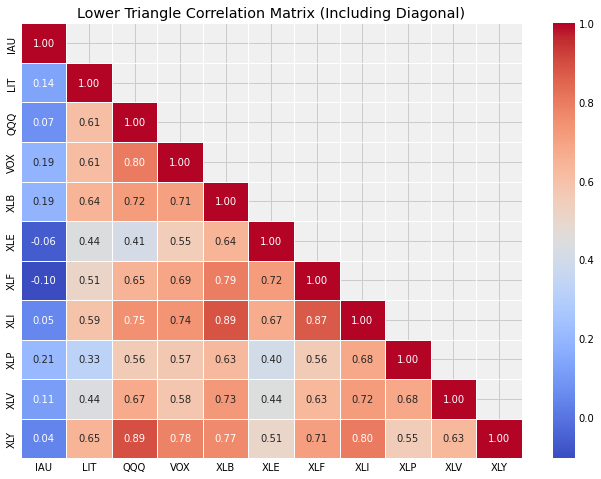

In [15]:
import seaborn as sns
# Step 1: Read monthly returns data
file_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
combined_returns = pd.read_csv(file_path, index_col=0)  # Set the date column as index

# Step 2: Compute the correlation matrix
correlation_matrix = combined_returns.corr()

# Step 3: Create a mask for the upper triangle (excluding the diagonal)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Step 4: Plot the heatmap with the mask
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Lower Triangle Correlation Matrix (Including Diagonal)")
plt.show()

<span style="color:blue;font-weight:bold;font-size:28px">Portfolio Construction</span>

In [16]:
import itertools

# Step 1: Define ETF groups
group1 = ['QQQ', 'XLY', 'VOX', 'XLI']
group2 = ['XLF', 'XLB', 'XLI']
group3 = ['IAU', 'XLV', 'XLP']  # Fixed group

# Step 2: Generate all combinations
combinations = []

# Loop through Group 1 and Group 2, ensuring no duplicate ETFs
for etf1 in group1:
    for etf2 in group2:
        if etf1 != etf2:  # Avoid selecting the same ETF (e.g., XLI)
            combo = [etf1, etf2] + group3  # Combine with Group 3
            combinations.append(combo)

# Step 3: Store results in DataFrame
combinations_df = pd.DataFrame(combinations, columns=["Group1_Rep", "Group2_Rep", "Group3_1", "Group3_2", "Group3_3"])

# Step 4: Display combinations and count
print("All possible 5-ETF combinations:")
print(combinations_df)
print(f"\nTotal number of combinations: {len(combinations_df)}")

# Step 5: Save combinations to 'portfolios.csv'
output_file = "portfolios.csv"
combinations_df.to_csv(output_file, index=False)
print(f"\nCombinations saved to: {output_file}")

All possible 5-ETF combinations:
   Group1_Rep Group2_Rep Group3_1 Group3_2 Group3_3
0         QQQ        XLF      IAU      XLV      XLP
1         QQQ        XLB      IAU      XLV      XLP
2         QQQ        XLI      IAU      XLV      XLP
3         XLY        XLF      IAU      XLV      XLP
4         XLY        XLB      IAU      XLV      XLP
5         XLY        XLI      IAU      XLV      XLP
6         VOX        XLF      IAU      XLV      XLP
7         VOX        XLB      IAU      XLV      XLP
8         VOX        XLI      IAU      XLV      XLP
9         XLI        XLF      IAU      XLV      XLP
10        XLI        XLB      IAU      XLV      XLP

Total number of combinations: 11

Combinations saved to: portfolios.csv


<span style="color:blue;font-weight:bold;font-size:28px"> Portfolio Optimization: Balancing Risk and Return</span>

<span style="color:blue;font-weight:bold;font-size:18px">1. Maximize Sharpe Ratio</span>

In [17]:
from scipy.optimize import minimize

# Portfolio Sharpe Ratio function (to maximize)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.018):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility  # Negative for maximization

# Optimization function
def optimize_sharpe_ratio(selected_etfs, returns_data):
    # Calculate mean returns and covariance matrix
    selected_returns = returns_data[selected_etfs]
    mean_returns = selected_returns.mean() * 12  # Annualized mean returns
    cov_matrix = selected_returns.cov() * 12  # Annualized covariance matrix
    num_assets = len(selected_etfs)

    # Initial equal weights
    initial_weights = np.array([1 / num_assets] * num_assets)

    # Constraints: Weights sum to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    # Bounds: for each ETF
    bounds = []
    for etf in selected_etfs:
        if etf in ['IAU', 'XLP']:  # Low-risk assets
            bounds.append((0.05, 0.5))  # Higher weight for low-risk assets
        elif etf in ['LIT', 'XLE']:  # High-risk assets
            bounds.append((0.01, 0.3))  # Lower weight for high-risk assets
        else:
            bounds.append((0.01, 0.4))  # Default bounds
    bounds = tuple(bounds)

    # Maximize Sharpe Ratio
    result = minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, 0.018),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x, -result.fun  # Optimized weights, maximum Sharpe Ratio

# Define portfolios
portfolios = {
    'Portfolio 1': ['QQQ', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 2': ['QQQ', 'XLB', 'IAU', 'XLV', 'XLP'],
    'Portfolio 3': ['QQQ', 'XLI', 'IAU', 'XLV', 'XLP'],
    'Portfolio 4': ['XLY', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 5': ['XLY', 'XLB', 'IAU', 'XLV', 'XLP'],
    'Portfolio 6': ['XLY', 'XLI', 'IAU', 'XLV', 'XLP'],
    'Portfolio 7': ['VOX', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 8': ['VOX', 'XLB', 'IAU', 'XLV', 'XLP'],
    'Portfolio 9': ['VOX', 'XLI', 'IAU', 'XLV', 'XLP'],
    'Portfolio 10': ['XLI', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 11': ['XLI', 'XLB', 'IAU', 'XLV', 'XLP']
}

# Load returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)

# Optimize each portfolio
sharpe_results = []

for portfolio_name, etfs in portfolios.items():
    try:
        optimized_weights, max_sharpe = optimize_sharpe_ratio(etfs, returns_data)
        result = {
            "Portfolio": portfolio_name,
            "Max Sharpe Ratio": round(max_sharpe, 5),
        }
        sharpe_results.append(result)
      
    except Exception as e:
        print(f"Error optimizing {portfolio_name}: {e}")

# Create a DataFrame for results
sharpe_df = pd.DataFrame(sharpe_results)

# Print the results
print("\n Sharpe Ratio Optimization Results ")
print(sharpe_df)

# Save results to a CSV file
output_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/sharpe_ratio_optimization_results.csv"
sharpe_df.to_csv(output_file, index=False)


 Sharpe Ratio Optimization Results 
       Portfolio  Max Sharpe Ratio
0    Portfolio 1           0.88153
1    Portfolio 2           0.86971
2    Portfolio 3           0.87297
3    Portfolio 4           0.72767
4    Portfolio 5           0.70828
5    Portfolio 6           0.71174
6    Portfolio 7           0.71010
7    Portfolio 8           0.66191
8    Portfolio 9           0.68366
9   Portfolio 10           0.71220
10  Portfolio 11           0.68231


<span style="color:blue;font-weight:bold;font-size:18px">2. Minimize Risk</span>

In [18]:
# Portfolio variance function (to minimize risk)
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Minimize risk function
def minimize_risk(selected_etfs, returns_data):
    selected_returns = returns_data[selected_etfs]
    cov_matrix = selected_returns.cov() * 12  # Annualized covariance matrix
    num_assets = len(selected_etfs)

    initial_weights = np.array([1 / num_assets] * num_assets)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = []
    for etf in selected_etfs:
        if etf in ['IAU', 'XLP']:  # Low-risk assets
            bounds.append((0.05, 0.5))  # Higher weight for low-risk assets
        elif etf in ['LIT', 'XLE']:  # High-risk assets
            bounds.append((0.01, 0.3))  # Lower weight for high-risk assets
        else:
            bounds.append((0.01, 0.4))  # Default bounds
    bounds = tuple(bounds)


    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, result.fun  # Optimized weights, minimized risk

# Load returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)

# Optimize each portfolio
results = []
for portfolio_name, etfs in portfolios.items():
    try:
        optimized_weights, min_risk = minimize_risk(etfs, returns_data)
        results.append({
            "Portfolio": portfolio_name,
            "Minimized Risk": round(min_risk, 5),
        })
    except Exception as e:
        print(f"Error optimizing {portfolio_name}: {e}")

# Save results
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/min_risk_results.csv", index=False)

       Portfolio  Minimized Risk
0    Portfolio 1         0.00975
1    Portfolio 2         0.00998
2    Portfolio 3         0.00994
3    Portfolio 4         0.00976
4    Portfolio 5         0.00998
5    Portfolio 6         0.00995
6    Portfolio 7         0.00977
7    Portfolio 8         0.00999
8    Portfolio 9         0.00996
9   Portfolio 10         0.00979
10  Portfolio 11         0.01000


/Users/peiqinhe/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


- **Portfolio 1** has the highest Sharpe Ratio (**0.88153**) and the lowest risk **0.00975**, making it the most efficient choice when balancing risk and return.  
- Other portfolios like Portfolio 3 also show a good balance, with a high Sharpe Ratio (0.87297) and relatively low risk (0.00994)
- **Portfolio 11** exhibit the highest minimized risks at **0.01000** , respectively, suggesting that this portfolios may be less favorable for minimizing risk under the current optimization framework.  
- The range of minimized risks across all portfolios is narrow (**0.00975 to 0.01000**), indicating relatively low risk dispersion among the portfolios.

<span style="color:blue;font-weight:bold;font-size:18px">3. Maximizing Portfolio Returns</span>

In [19]:
from scipy.optimize import minimize

# Function to calculate the negative portfolio return (for maximization)
def negative_portfolio_return(weights, mean_returns):
    return -np.dot(weights, mean_returns)  # Negative for maximization

# Optimization function for maximum return
def optimize_max_return(selected_etfs, returns_data):
    # Calculate mean returns for the selected ETFs
    selected_returns = returns_data[selected_etfs]
    mean_returns = selected_returns.mean() * 12  # Annualized mean returns
    num_assets = len(selected_etfs)

    # Initial equal weights
    initial_weights = np.array([1 / num_assets] * num_assets)

    # Constraints: Weights sum to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

    # Dynamic bounds based on ETF categories
    bounds = []
    for etf in selected_etfs:
        if etf in ['IAU', 'XLP']:  # Low-risk assets
            bounds.append((0.05, 0.5))  # Higher weight for low-risk assets
        elif etf in ['LIT', 'XLE']:  # High-risk assets
            bounds.append((0.01, 0.3))  # Lower weight for high-risk assets
        else:
            bounds.append((0.01, 0.4))  # Default bounds
    bounds = tuple(bounds)

    # Minimize the negative portfolio return to maximize the return
    result = minimize(negative_portfolio_return, initial_weights, args=(mean_returns,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.fun, result.x  # Return the optimized return and weights

# Load returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)

# Step 6: Optimize for maximum return
max_return_results = []

for portfolio_name, etfs in portfolios.items():
    try:
        max_return, optimized_weights = optimize_max_return(etfs, returns_data)
        max_return_results.append({
            "Portfolio": portfolio_name,
            "Maximized Return": round(-max_return, 5),  # Convert negative return to positive
        })
    except Exception as e:
        print(f"Error optimizing {portfolio_name} for max return: {e}")

# Convert results to DataFrame
max_return_df = pd.DataFrame(max_return_results)

# Print the results
print("\n Max Return Optimization Results ")
print(max_return_df)

# Save to CSV
output_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/max_return_optimization_results.csv"
max_return_df.to_csv(output_file, index=False)


 Max Return Optimization Results 
       Portfolio  Maximized Return
0    Portfolio 1           0.13021
1    Portfolio 2           0.12156
2    Portfolio 3           0.12973
3    Portfolio 4           0.11263
4    Portfolio 5           0.10398
5    Portfolio 6           0.11215
6    Portfolio 7           0.09877
7    Portfolio 8           0.08826
8    Portfolio 9           0.09829
9   Portfolio 10           0.10767
10  Portfolio 11           0.09902


### Analysis:
- While **Portfolio 1** stands out as the most return-efficient option, further analysis is required to refine portfolio selection.  
- We will subsequently conduct a correlation analysis to adjust and eliminate highly correlated portfolios, which will allow us to validate and finalize the selection of optimal portfolios.

<span style="color:blue;font-weight:bold;font-size:18px">4.1 Portfolio Risk Assessment: Internal Correlations</span>

In [20]:
# Step 1: Load returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)


# Step 3: Calculate and print correlation matrices for each portfolio
for portfolio_name, etfs in portfolios.items():
    # Extract data for the current portfolio
    selected_returns = returns_data[etfs]
    
    # Calculate the correlation matrix
    correlation_matrix = selected_returns.corr()
    
    # Print the correlation matrix
    print(f"\nCorrelation Matrix for {portfolio_name}:")
    print(correlation_matrix.round(2))  # Round to 2 decimal places for readability


Correlation Matrix for Portfolio 1:
      QQQ   XLF   IAU   XLV   XLP
QQQ  1.00  0.65  0.07  0.67  0.56
XLF  0.65  1.00 -0.10  0.63  0.56
IAU  0.07 -0.10  1.00  0.11  0.21
XLV  0.67  0.63  0.11  1.00  0.68
XLP  0.56  0.56  0.21  0.68  1.00

Correlation Matrix for Portfolio 2:
      QQQ   XLB   IAU   XLV   XLP
QQQ  1.00  0.72  0.07  0.67  0.56
XLB  0.72  1.00  0.19  0.73  0.63
IAU  0.07  0.19  1.00  0.11  0.21
XLV  0.67  0.73  0.11  1.00  0.68
XLP  0.56  0.63  0.21  0.68  1.00

Correlation Matrix for Portfolio 3:
      QQQ   XLI   IAU   XLV   XLP
QQQ  1.00  0.75  0.07  0.67  0.56
XLI  0.75  1.00  0.05  0.72  0.68
IAU  0.07  0.05  1.00  0.11  0.21
XLV  0.67  0.72  0.11  1.00  0.68
XLP  0.56  0.68  0.21  0.68  1.00

Correlation Matrix for Portfolio 4:
      XLY   XLF   IAU   XLV   XLP
XLY  1.00  0.71  0.04  0.63  0.55
XLF  0.71  1.00 -0.10  0.63  0.56
IAU  0.04 -0.10  1.00  0.11  0.21
XLV  0.63  0.63  0.11  1.00  0.68
XLP  0.55  0.56  0.21  0.68  1.00

Correlation Matrix for Portfolio 5:

# Correlation Analysis for Portfolios

## Portfolio 1
**Observation**:  
- QQQ and XLF show a moderate correlation of **0.65**.  
- IAU (Gold) has very low correlation with other assets (around **0.07** to **0.21**), which provides excellent diversification.  

**Recommendation**:  
- The overall diversification is reasonable. This portfolio can be retained as it balances low and moderate correlations effectively.

## Portfolio 2
**Observation**:  
- QQQ and XLB have a relatively high correlation of **0.72**.  
- XLV and XLB are also moderately correlated (**0.73**).  
- IAU maintains low correlation.  

**Recommendation**:  
- **Remove Portfolio 2** due to strong correlations within the group, specifically between QQQ and XLB.


## Portfolio 3
**Observation**:  
- QQQ and XLI have a high correlation of **0.75**.  
- IAU again has a very low correlation (**0.05** to **0.21**).  

**Recommendation**:  
- To improve diversification, **remove either QQQ or XLI** to reduce the strong correlation.


## Portfolio 4
**Observation**:  
- XLY and XLF are moderately correlated at **0.71**.  
- IAU provides significant diversification with a correlation as low as **0.04**.  

**Recommendation**:  
- To improve diversification, **remove either XLY or XLF** to reduce the strong correlation


## Portfolio 5
**Observation**:  
- XLY and XLB have a high correlation of **0.77**.  
- XLV and XLB also exhibit moderate correlation at **0.73**.  

**Recommendation**:  
- **Remove Portfolio 5** because multiple assets (XLY and XLB) are highly correlated, limiting diversification.


## Portfolio 6
**Observation**:  
- XLY and XLI have a very strong correlation of **0.80**.  
- IAU provides excellent diversification with very low correlation (**0.04** to **0.21**).  

**Recommendation**:  
- **Remove either XLY or XLI** to reduce the correlation and improve portfolio diversification.


## Portfolio 7
**Observation**:  
- VOX and XLF show a moderate correlation of **0.69**.  
- IAU maintains low correlation with other ETFs, improving diversification.  

**Recommendation**:  
- Retain Portfolio 7 as it has relatively good diversification with manageable correlations.


## Portfolio 8
**Observation**:  
- VOX and XLB exhibit a relatively high correlation of **0.71**.  
- IAU maintains low correlation, which offsets some of the concentration risk.  

**Recommendation**:  
- To improve diversification, **remove either VOX or XLB** to reduce the strong correlation

---

## Portfolio 9
**Observation**:  
- VOX and XLI have a relatively high correlation of **0.74**.  
- IAU continues to diversify with correlations as low as **0.05**.  

**Recommendation**:  
- **Remove either VOX or XLI** to mitigate the strong correlation.

---

## Portfolio 10
**Observation**:  
- XLI and XLF have an extremely high correlation of **0.87**.  
- XLV and XLP remain moderately correlated (**0.68**).  

**Recommendation**:  
- **Remove either XLI or XLF** due to their very strong correlation.

---

## Portfolio 11
**Observation**:  
- XLI and XLB have a very high correlation of **0.89**.  
- XLB and XLV also exhibit high correlation (**0.73**).  

**Recommendation**:  
- **Remove Portfolio 11** entirely due to high risk and strong internal correlations inside


# Final Portfolio Recommendations

## Portfolios to Remove Entirely  
- **Portfolio 2**: Excessive internal correlation, particularly between QQQ and XLB.  
- **Portfolio 5**: High correlation between XLY and XLB, reducing diversification benefits.  
- **Portfolio 11**: Strong correlations, especially between XLI and XLB, making this portfolio redundant.  

## Adjusted Portfolios  
Following the removal of highly correlated ETFs, the remaining portfolios and their revised ETF combinations are:

### Portfolio 3
**ETFs**: QQQ, IAU, XLV, XLP  
- Removed **QQQ** to reduce correlation with XLI.

### Portfolio 4  
**ETFs**: XLY, IAU, XLV, XLP  
- Removed **XLF** due to strong correlation with XLY.

### Portfolio 6 
**ETFs**: 'XLY', , 'IAU', 'XLV', 'XLP' 
- No matter remove XLY or XLI, will generate same portfolio with 3 or 4, so delete this portfolio.

### Portfolio 8 
**ETFs**: 'VOX','IAU', 'XLV', 'XLP'  
- Removed **XLB** due to strong correlation with VOX.

### Portfolio 9 
**ETFs**:'XLI', 'IAU', 'XLV', 'XLP'
- Removed **VOX** due to strong correlation with XLI

### Portfolio 10  
**ETFs**:'XLF', 'IAU', 'XLV', 'XLP'
- Removed **XLI** due to strong correlation with XLF

# Renewed Portfolios  
1. **Portfolio 1**: 'QQQ', 'XLF', 'IAU', 'XLV', 'XLP'  
2. **Portfolio 2**: QQQ, IAU, XLV, XLP  
3. **Portfolio 3**: XLY, IAU, XLV, XLP  
4. **Portfolio 4**: 'VOX', 'XLF', 'IAU', 'XLV', 'XLP' 
5. **Portfolio 5**: 'VOX','IAU', 'XLV', 'XLP' 
6. **Portfolio 6**: 'XLI','IAU', 'XLV', 'XLP'
6. **Portfolio 7**: 'XLF', 'IAU', 'XLV', 'XLP'

Summary:

	1.	All portfolios are free of redundant ETFs and overlapping combinations.
	2.	IAU (Gold) consistently provides diversification across all portfolios, as it has the lowest correlation with other ETFs.
	3.	The remaining portfolios maintain balance between growth-oriented sectors (QQQ, XLY, VOX) and defensive sectors (XLP, XLV, IAU).

<span style="color:blue;font-weight:bold;font-size:18px">4.2.Correlation Matrix Validation and Stability Check</span>

In [21]:
# Renewed Portfolios
portfolios = {
    'Portfolio 1': ['QQQ', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 2': ['QQQ', 'IAU', 'XLV', 'XLP'],
    'Portfolio 3': ['XLY', 'IAU', 'XLV', 'XLP'],
    'Portfolio 4': ['VOX', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 5': ['VOX', 'IAU', 'XLV', 'XLP'],
    'Portfolio 6': ['XLI','IAU', 'XLV', 'XLP'],
    'Portfolio 7': ['XLF', 'IAU', 'XLV', 'XLP'],
}

# Load returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)

# Analyze each portfolio's internal correlation
results = []

for portfolio_name, etfs in portfolios.items():
    selected_returns = returns_data[etfs]
    correlation_matrix = selected_returns.corr()
    
    # Calculate average and maximum correlation
    avg_corr = correlation_matrix.mean().mean()  # Average correlation
    max_corr = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape, dtype=bool), k=1)).max().max()  # Maximum correlation

    # Store results
    results.append({
        'Portfolio': portfolio_name,
        'Average Correlation': round(avg_corr, 4),
        'Maximum Correlation': round(max_corr, 4)
    })
    
    # Print correlation matrix
    print(f"\n{portfolio_name} Correlation Matrix:")
    print(correlation_matrix.round(2))

# Convert results to DataFrame and print
results_df = pd.DataFrame(results)
print("\nPortfolio Correlation Analysis:")
print(results_df)

# Save results to CSV
output_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/correlation_analysis_02.csv"
results_df.to_csv(output_file, index=False)


Portfolio 1 Correlation Matrix:
      QQQ   XLF   IAU   XLV   XLP
QQQ  1.00  0.65  0.07  0.67  0.56
XLF  0.65  1.00 -0.10  0.63  0.56
IAU  0.07 -0.10  1.00  0.11  0.21
XLV  0.67  0.63  0.11  1.00  0.68
XLP  0.56  0.56  0.21  0.68  1.00

Portfolio 2 Correlation Matrix:
      QQQ   IAU   XLV   XLP
QQQ  1.00  0.07  0.67  0.56
IAU  0.07  1.00  0.11  0.21
XLV  0.67  0.11  1.00  0.68
XLP  0.56  0.21  0.68  1.00

Portfolio 3 Correlation Matrix:
      XLY   IAU   XLV   XLP
XLY  1.00  0.04  0.63  0.55
IAU  0.04  1.00  0.11  0.21
XLV  0.63  0.11  1.00  0.68
XLP  0.55  0.21  0.68  1.00

Portfolio 4 Correlation Matrix:
      VOX   XLF   IAU   XLV   XLP
VOX  1.00  0.69  0.19  0.58  0.57
XLF  0.69  1.00 -0.10  0.63  0.56
IAU  0.19 -0.10  1.00  0.11  0.21
XLV  0.58  0.63  0.11  1.00  0.68
XLP  0.57  0.56  0.21  0.68  1.00

Portfolio 5 Correlation Matrix:
      VOX   IAU   XLV   XLP
VOX  1.00  0.19  0.58  0.57
IAU  0.19  1.00  0.11  0.21
XLV  0.58  0.11  1.00  0.68
XLP  0.57  0.21  0.68  1.00

Portfo

### Summary
-In Portfolio 6, **XLV** and **XLI** are highly correlated (0.72). No matter remove which one , this portfolio overlaps with other portfolios, making it redundant, so just delete this portfolio.

-In Portfolio 4, **VOX** and **XLF** are strongly correlated. No matter remove which one , this portfolio overlaps with other portfolios, making it redundant, so just delete this portfolio.

<span style="color:blue;font-weight:bold;font-size:18px">5.Refining Portfolio Selection: Covariance and Correlation Analysis</span>

In [22]:
portfolios = {
    'Portfolio 1': ['QQQ', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 2': ['QQQ', 'IAU', 'XLV', 'XLP'],
    'Portfolio 3': ['XLY', 'IAU', 'XLV', 'XLP'],
    'Portfolio 4': ['VOX', 'IAU', 'XLV', 'XLP'],
}

# Step 1: Load the returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)

# Step 2: Calculate and check covariance matrix for each portfolio
for portfolio_name, etfs in portfolios.items():
    # Extract returns for the specific ETFs in the portfolio
    selected_returns = returns_data[etfs]
    
    # Calculate the annualized covariance matrix
    cov_matrix = selected_returns.cov() * 12
    
    # Check determinant
    det = np.linalg.det(cov_matrix)
    if det < 1e-10:  # Threshold for near-singularity
        print(f"Warning: {portfolio_name}'s covariance matrix may be near-singular! Determinant: {det:.5e}")
        print(f"ETFs in {portfolio_name}: {etfs}")
    else:
        print(f"{portfolio_name} determinant: {det:.5e}")
        
        avg_corr = selected_returns.corr().mean().mean()
        print(f"{portfolio_name} Average Correlation: {avg_corr:.2f}")

Portfolio 1 determinant: 1.05473e-09
Portfolio 1 Average Correlation: 0.52
Portfolio 2 determinant: 5.81159e-08
Portfolio 2 Average Correlation: 0.54
Portfolio 3 determinant: 7.27903e-08
Portfolio 3 Average Correlation: 0.53
Portfolio 4 determinant: 6.08924e-08
Portfolio 4 Average Correlation: 0.54


<span style="color:blue;font-weight:bold;font-size:28px">Portfolios Optimization</span>

<span style="color:blue;font-weight:bold;font-size:18px">1. Portfolios Covariance Matrix</span>

In [23]:
# Step 1: Define portfolios manually
portfolios = {
    'Portfolio 1': ['QQQ', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 2': ['QQQ', 'IAU', 'XLV', 'XLP'],
    'Portfolio 3': ['XLY', 'IAU', 'XLV', 'XLP'],
    'Portfolio 4': ['VOX', 'IAU', 'XLV', 'XLP'],
}

# Step 2: Load the real returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)

# Step 3: Define a function to calculate portfolio metrics
def calculate_portfolio_metrics(selected_etfs, returns_data):
    selected_data = returns_data[selected_etfs]  # Extract ETF returns
    weights = np.array([1 / len(selected_etfs)] * len(selected_etfs))  # Equal weights

    # Annualized mean return
    mean_returns = selected_data.mean() * 12
    portfolio_return = np.dot(weights, mean_returns)  # Weighted mean return for portfolio

    # Annualized covariance matrix
    cov_matrix = selected_data.cov() * 12

    # Portfolio variance and standard deviation
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)

    return portfolio_return, portfolio_std_dev, portfolio_variance

# Step 4: Calculate metrics for each portfolio
results = []

for portfolio_name, etfs in portfolios.items():
    portfolio_return, portfolio_std_dev, portfolio_variance = calculate_portfolio_metrics(etfs, returns_data)
    results.append({
        'Portfolio': portfolio_name,
        'Expected Return': round(portfolio_return, 5),
        'Volatility': round(portfolio_std_dev, 5),
        'Variance': round(portfolio_variance, 5)
    })

# Step 5: Save the results
results_df = pd.DataFrame(results)
output_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/portfolio_metrics_clean.csv"
results_df.to_csv(output_file, index=False)

# Step 6: Display the results
print(results_df)

     Portfolio  Expected Return  Volatility  Variance
0  Portfolio 1          0.10710     0.11616   0.01349
1  Portfolio 2          0.10550     0.10941   0.01197
2  Portfolio 3          0.09451     0.11109   0.01234
3  Portfolio 4          0.08323     0.10833   0.01173


## Analysis of Portfolio Covariance Matrix Results

- **Risk-Seeking Investors**: Portfolio 1 is the best choice due to its high expected return, despite its higher risk and variance.
- **Balanced Approach**: Portfolio 2 stands out as the optimal tradeoff between return and risk, with relatively high returns and lower volatility.
- **Risk-Averse Investors**: Portfolio 4 provides the lowest risk but at the cost of significantly reduced returns.
- **Portfolio 3**: While offering moderate return and risk, Portfolio 3 is slightly outperformed by Portfolio 2 in terms of risk-adjusted performance.

---

### Conclusion
From this analysis, Portfolio 2 appears to be the most favorable choice for investors seeking a balance between risk and return. Portfolio 1 is a strong candidate for aggressive investors, while Portfolio 4 caters to conservative risk-averse individuals. Portfolio 3, although balanced, does not outperform Portfolio 2 and therefore may not be the optimal choice.

 <span style="color:blue;font-weight:bold;font-size:18px">2.Constrained Minimum-Variance Optimization: Sharpe Ratio Maximization</span>

In [24]:
# ETF_BOUNDS
ETF_BOUNDS = {
    'QQQ': (0.30, 0.40),  # Tech stocks: 30-40%
    'IAU': (0.10, 0.20),  # Gold: 10-20%
    'XLP': (0.05, 0.30),  # Consumer Staples: 5-30%
    'XLV': (0.05, 0.30),  # Healthcare: 5-30%
    'XLY': (0.05, 0.30),  # Consumer Discretionary: 5-30%
    'VOX': (0.05, 0.30),  # Communication Services: 5-30%
    'XLF': (0.05, 0.30),  # Financials: 5-30%
}

# Sharpe Ratio optimization
def optimize_sharpe_ratio(selected_etfs, returns_data, mean_returns, risk_free_rate):
    cov_matrix = returns_data[selected_etfs].cov() * 12
    num_assets = len(selected_etfs)
    initial_weights = np.array([1 / num_assets] * num_assets)

    def negative_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility  # Negative for maximization

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [ETF_BOUNDS.get(etf, (0.05, 0.30)) for etf in selected_etfs]

    result = minimize(
        negative_sharpe_ratio,
        initial_weights,
        method='trust-constr',
        bounds=bounds,
        constraints=constraints
    )

    return result.x, -result.fun  # Returns weights and max Sharpe Ratio

# Load returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)

# Define portfolios
portfolios = {
    'Portfolio 1': ['QQQ', 'XLF', 'IAU', 'XLV', 'XLP'],
    'Portfolio 2': ['QQQ', 'IAU', 'XLV', 'XLP'],
    'Portfolio 3': ['XLY', 'IAU', 'XLV', 'XLP'],
    'Portfolio 4': ['VOX', 'IAU', 'XLV', 'XLP'],
}

# Calculate mean returns (historical or CAPM-based)
mean_returns = returns_data.mean() * 12  # Example: annualized historical mean returns
risk_free_rate = 0.02  # 2% annual risk-free rate

# Optimize each portfolio
all_portfolios = []

for portfolio_name, etfs in portfolios.items():
    optimized_weights, max_sharpe = optimize_sharpe_ratio(etfs, returns_data, mean_returns[etfs], risk_free_rate)

    # Save portfolio results
    portfolio_df = pd.DataFrame({
        'Portfolio': portfolio_name,
        'ETF': etfs,
        'Optimized Weight': np.round(optimized_weights, 5),
        'Sharpe Ratio': [round(max_sharpe, 5)] * len(etfs)
    })

    all_portfolios.append(portfolio_df)

    # Print results
    print(f"\n{portfolio_name} - Max Sharpe Ratio: {max_sharpe:.5f}")
    print(portfolio_df)

# Combine results into one DataFrame
final_df = pd.concat(all_portfolios)

# Save results
final_df.to_csv("/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/optimized_weights_sharpe.csv", index=False)

/Users/peiqinhe/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



Portfolio 1 - Max Sharpe Ratio: 0.79930
     Portfolio  ETF  Optimized Weight  Sharpe Ratio
0  Portfolio 1  QQQ           0.32718        0.7993
1  Portfolio 1  XLF           0.12934        0.7993
2  Portfolio 1  IAU           0.19969        0.7993
3  Portfolio 1  XLV           0.16868        0.7993
4  Portfolio 1  XLP           0.17511        0.7993


/Users/peiqinhe/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



Portfolio 2 - Max Sharpe Ratio: 0.81675
     Portfolio  ETF  Optimized Weight  Sharpe Ratio
0  Portfolio 2  QQQ           0.39637       0.81675
1  Portfolio 2  IAU           0.19746       0.81675
2  Portfolio 2  XLV           0.18489       0.81675
3  Portfolio 2  XLP           0.22128       0.81675


/Users/peiqinhe/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



Portfolio 3 - Max Sharpe Ratio: 0.65790
     Portfolio  ETF  Optimized Weight  Sharpe Ratio
0  Portfolio 3  XLY           0.28320        0.6579
1  Portfolio 3  IAU           0.19990        0.6579
2  Portfolio 3  XLV           0.27637        0.6579
3  Portfolio 3  XLP           0.24053        0.6579

Portfolio 4 - Max Sharpe Ratio: 0.58703
     Portfolio  ETF  Optimized Weight  Sharpe Ratio
0  Portfolio 4  VOX           0.20030       0.58703
1  Portfolio 4  IAU           0.19994       0.58703
2  Portfolio 4  XLV           0.29985       0.58703
3  Portfolio 4  XLP           0.29990       0.58703


/Users/peiqinhe/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


## Analysis of Max Sharpe Ratios and Optimized Weights

### Portfolio Summaries

1. **Portfolio 1**  
   - Portfolio 1 demonstrates strong risk-adjusted returns with a balanced allocation across all ETFs, making it a reliable choice for investors seeking moderate diversification and performance.

2. **Portfolio 2**  
   - Portfolio 2 achieves the highest Sharpe ratio among the four portfolios, largely due to a higher allocation to growth-oriented and stable sectors. It is the most attractive option for maximizing risk-adjusted returns.

3. **Portfolio 3**  
   - Portfolio 3 has a moderate Sharpe ratio, reflecting a focus on consumer discretionary stocks. While it provides reasonable diversification, its risk-adjusted performance is less competitive compared to Portfolios 1 and 2.

4. **Portfolio 4**  
   - Portfolio 4 shows the lowest Sharpe ratio, emphasizing diversification but at the expense of lower overall efficiency. It may appeal to conservative investors prioritizing stability over returns.

---

### Final Summary
Among the four portfolios, Portfolio 2 stands out as the optimal choice for maximizing risk-adjusted returns. Portfolio 1 is a strong secondary option for those seeking a balanced approach. Portfolios 3 and 4 lag behind in performance, with Portfolio 4 being the least favorable due to its lower efficiency.

 <span style="color:blue;font-weight:bold;font-size:18px">2.2. Minimum Variance Allocation</span>

In [25]:
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0")
warnings.filterwarnings("ignore", message="Singular Jacobian matrix")

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Enforce QQQ >= 25%
def technology_sector_constraint(weights, selected_etfs):
    tech_index = [i for i, etf in enumerate(selected_etfs) if etf == 'QQQ']
    if tech_index:
        return weights[tech_index[0]] - 0.25  # At least 25% in QQQ
    return 0

# Define per-ETF (min, max) bounds
ETF_BOUNDS = {
    'IAU': (0.05, 0.2),
    'XLV': (0.05, 0.5),
    'XLP': (0.05, 0.5),
    'QQQ': (0.25, 0.5),
    'XLF': (0.01, 0.4),
    'XLY': (0.01, 0.4),
    'VOX': (0.01, 0.4),
    # No high-risk assets like XLE, LIT if you have removed them
}

def optimize_portfolio(selected_etfs, returns_data):
    selected_returns = returns_data[selected_etfs]
    cov_matrix = selected_returns.cov() * 12
    num_assets = len(selected_etfs)

    initial_weights = np.array([1 / num_assets] * num_assets)

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: np.min(w) - 0.05},
        {'type': 'ineq', 'fun': technology_sector_constraint, 'args': (selected_etfs,)}
    ]

    # Apply per-ETF bounds from the dictionary
    bounds = []
    for etf in selected_etfs:
        bounds.append(ETF_BOUNDS.get(etf, (0.01, 0.4)))
    bounds = tuple(bounds)

    result = minimize(
    portfolio_variance,
    initial_weights,
    args=(cov_matrix,),
    method='trust-constr',
    bounds=bounds,
    constraints=constraints,
    options={'verbose': 0, 'disp': False}  # <= add this line
)
    return result.x, result.fun  # Returns optimized weights and minimized variance

# Step 5: Load returns data
returns_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
returns_data = pd.read_csv(returns_file, index_col=0)

# Step 6: Optimize each portfolio and save results
for portfolio_name, etfs in portfolios.items():
    optimized_weights, min_variance = optimize_portfolio(etfs, returns_data)

    # Create and display DataFrame
    portfolio_df = pd.DataFrame({
        'ETF': etfs,
        'Optimized Weight': np.round(optimized_weights, 5)
    })

    # Save to CSV
  # Collect all portfolio weights into a list
all_portfolios = []

for portfolio_name, etfs in portfolios.items():
    optimized_weights, min_variance = optimize_portfolio(etfs, returns_data)

    # Create DataFrame for the current portfolio
    portfolio_df = pd.DataFrame({
        'Portfolio': portfolio_name,
        'ETF': etfs,
        'Optimized Weight': np.round(optimized_weights, 5)
    })

    all_portfolios.append(portfolio_df)

    print(f"\n{portfolio_name} - Minimized Variance: {min_variance:.5f}")
    print(portfolio_df)

# Combine all portfolios into one DataFrame
final_df = pd.concat(all_portfolios)

# Save to CSV
output_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/optimal_weight_allocation.csv"
final_df.to_csv(output_file, index=False)


Portfolio 1 - Minimized Variance: 0.01393
     Portfolio  ETF  Optimized Weight
0  Portfolio 1  QQQ           0.27095
1  Portfolio 1  XLF           0.15891
2  Portfolio 1  IAU           0.18722
3  Portfolio 1  XLV           0.15957
4  Portfolio 1  XLP           0.22334

Portfolio 2 - Minimized Variance: 0.01310
     Portfolio  ETF  Optimized Weight
0  Portfolio 2  QQQ           0.29322
1  Portfolio 2  IAU           0.18975
2  Portfolio 2  XLV           0.24620
3  Portfolio 2  XLP           0.27082

Portfolio 3 - Minimized Variance: 0.01268
     Portfolio  ETF  Optimized Weight
0  Portfolio 3  XLY           0.21146
1  Portfolio 3  IAU           0.18685
2  Portfolio 3  XLV           0.28246
3  Portfolio 3  XLP           0.31922

Portfolio 4 - Minimized Variance: 0.01261
     Portfolio  ETF  Optimized Weight
0  Portfolio 4  VOX           0.22222
1  Portfolio 4  IAU           0.19721
2  Portfolio 4  XLV           0.42182
3  Portfolio 4  XLP           0.15874


## Analysis of Minimized Variance and Optimized Weights

### Portfolio Summaries

1. **Portfolio 1**  
   - Portfolio 1 demonstrates a balanced allocation strategy, achieving a relatively low variance. It provides a reasonable diversification of risk, making it a stable option for investors seeking moderate risk reduction.

2. **Portfolio 2**  
   - Portfolio 2 achieves the second-lowest variance with slightly higher allocations to QQQ and XLP. This combination of weights provides strong risk minimization while maintaining exposure to growth-oriented and stable sectors.

3. **Portfolio 3**  
   - Portfolio 3 offers a marginally lower variance than Portfolio 2. With a focus on consumer discretionary (XLY) and stable sectors, it strikes a balance between risk reduction and diversification but may have slightly higher sector concentration.

4. **Portfolio 4**  
   - Portfolio 4 achieves the lowest variance among the four portfolios, emphasizing stability through higher allocations to XLV and VOX. This portfolio is particularly suitable for highly risk-averse investors prioritizing minimized variability.

---

### Final Summary
Portfolio 4 stands out as the most efficient portfolio for minimizing variance, offering the lowest risk among the four options. Portfolio 3 closely follows, providing a balanced approach with slightly lower variance. Portfolio 1 and Portfolio 2 are also competitive choices, with Portfolio 2 offering the most strategic balance between risk reduction and sector allocation.

<span style="color:blue;font-weight:bold;font-size:18px">3. CAPM Analysis</span>

In [26]:
import yfinance as yf
# Step 1: Download S&P 500 data from Yahoo Finance
sp500_data = yf.download("^GSPC", start="2015-01-01", end="2024-12-31", interval="1mo")

# Step 2: Use the adjusted close prices
sp500_data = sp500_data[['Adj Close']].rename(columns={'Adj Close': 'SP500_Price'})

# Step 3: Calculate market returns (monthly % change)
sp500_data['Market_Return'] = sp500_data['SP500_Price'].pct_change()

# Drop the first row (NaN due to pct_change) and reset the index
sp500_data.dropna(inplace=True)
sp500_data.reset_index(inplace=True)

# Save to a CSV (optional)
sp500_data.to_csv("/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/sp500_returns.csv", index=False)

print(sp500_data.head())

[*********************100%***********************]  1 of 1 completed
        Date  SP500_Price  Market_Return
0 2015-02-01  2104.500000       0.054893
1 2015-03-01  2067.889893      -0.017396
2 2015-04-01  2085.510010       0.008521
3 2015-05-01  2107.389893       0.010491
4 2015-06-01  2063.110107      -0.021012


In [27]:
import statsmodels.api as sm

# Step 1: Load portfolio data
file_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/all_portfolios_table.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])

# Step 2: Load S&P 500 market returns data
sp500_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/sp500_returns.csv"
sp500_data = pd.read_csv(sp500_file, parse_dates=['Date'])

# Step 3: Merge portfolio data with market return data on 'Date'
df = pd.merge(df, sp500_data[['Date', 'Market_Return']], on='Date', how='inner')

# Ensure the data is sorted by date
df.sort_values(by='Date', inplace=True)

# Step 2: Set risk-free rate (constant value, e.g., 0.02 or 2%)
risk_free_rate = 0.02

# If the file already includes RF column, this line overrides it to use the constant value
df['RF'] = risk_free_rate

# Step 3: Calculate EXCESS returns = (portfolio_return - risk_free_rate)
df['Portfolio_Excess'] = df['Return'] - df['RF']
df['Market_Excess']    = df['Market_Return'] - df['RF']

# Step 4: Group by portfolio (if you have multiple portfolios in the same file)
unique_portfolios = df['Portfolio'].unique()
capm_results = []

for p in unique_portfolios:
    # Filter data for the specific portfolio
    sub = df[df['Portfolio'] == p].dropna()

    # Dependent var: portfolio's excess returns
    y = sub['Portfolio_Excess']

    # Independent var: market's excess returns (plus a constant for alpha)
    X = sm.add_constant(sub['Market_Excess'])

    # Step 5: Run OLS regression
    model = sm.OLS(y, X).fit()
    alpha = model.params['const']    # CAPM alpha
    beta  = model.params['Market_Excess']
    p_val_alpha = model.pvalues['const']
    p_val_beta  = model.pvalues['Market_Excess']

    # Store results
    capm_results.append({
        'Portfolio': p,
        'Alpha': alpha,
        'Beta': beta,
        'Alpha_pvalue': p_val_alpha,
        'Beta_pvalue': p_val_beta,
        'R-squared': model.rsquared
    })

# Convert to DataFrame for easy viewing
capm_df = pd.DataFrame(capm_results)
print(capm_df)

     Portfolio     Alpha      Beta  Alpha_pvalue   Beta_pvalue  R-squared
0  Portfolio 1 -0.004060  0.721742      0.004355  4.917314e-84   0.473821
1  Portfolio 4 -0.007394  0.599437      0.000003  2.783310e-52   0.389265
2  Portfolio 3 -0.005970  0.646507      0.000225  1.905624e-56   0.413609
3  Portfolio 2 -0.005217  0.630800      0.000882  6.999464e-57   0.416096


## Summary Analysis of CAPM Metrics

Among the four portfolios, **Portfolio 2** demonstrates the best overall performance. While all portfolios have negative Alpha values, Portfolio 2 exhibits the least negative Alpha, indicating relatively better risk-adjusted returns compared to the others. Additionally, its Beta and R-squared suggest moderate sensitivity to market movements and decent explanatory power of market returns.

**Portfolio 1** follows closely with the highest R-squared, implying stronger alignment with market returns, but its slightly more negative Alpha limits its appeal.

**Portfolio 3** and **Portfolio 4** lag behind, with Portfolio 4 showing the weakest performance due to its highly negative Alpha and lower R-squared, despite having the lowest Beta, reflecting reduced market sensitivity.

In conclusion, **Portfolio 2** stands out as the most favorable choice for balancing market sensitivity and performance metrics.

<span style="color:blue;font-weight:bold;font-size:18px">4. Yearly Portfolio Analysis: Risk, Return, and Trends</span>

Yearly Portfolio Performance
    Year    Portfolio  Annualized Return (pct)  Volatility  Sharpe Ratio
0   2015  Portfolio 1                 0.004912    0.030043     -0.502223
4   2016  Portfolio 1                 0.014563    0.030273     -0.179610
8   2017  Portfolio 1                 0.038339    0.017253      1.062916
12  2018  Portfolio 1                -0.007058    0.032321     -0.837147
16  2019  Portfolio 1                 0.050566    0.026865      1.137736
20  2020  Portfolio 1                 0.037788    0.046432      0.383096
24  2021  Portfolio 1                 0.035770    0.029384      0.536675
28  2022  Portfolio 1                -0.025164    0.044045     -1.025407
32  2023  Portfolio 1                 0.031995    0.034202      0.350704
36  2024  Portfolio 1                 0.046961    0.022666      1.189524
Saved yearly stats to: /Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/yearly_portfolio_stats.csv


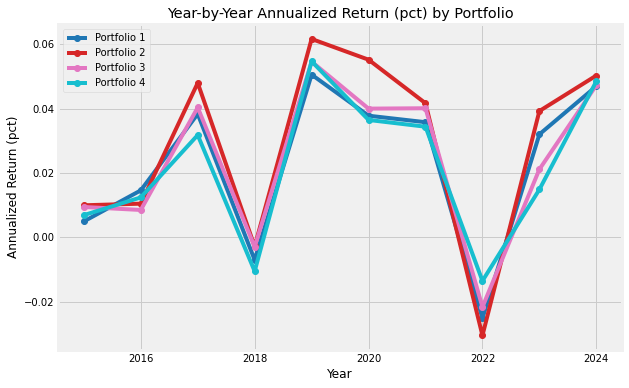

In [28]:
def load_and_aggregate_by_year(csv_path):
    
    if not os.path.exists(csv_path):
        print("ERROR: File does not exist:", csv_path)
        return pd.DataFrame()

    df = pd.read_csv(csv_path)

    # Parse the Date column, assuming format 'YYYY-MM'
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m', errors='coerce')
    df.sort_values('Date', inplace=True)

    # Extract the Year
    df['Year'] = df['Date'].dt.year

    # Compute the monthly weighted return
    df['Weighted_Return'] = df['Weight'] * df['Return']

    return df

def compute_annual_stats_by_year(df, risk_free=0.02):
   
    results = []

    grouped = df.groupby(['Year', 'Portfolio'])

    for (year, portfolio), group_data in grouped:
        monthly_returns = group_data['Weighted_Return'].dropna()
        if len(monthly_returns) == 0:
            continue

        mean_monthly = monthly_returns.mean()
        annual_log_return = mean_monthly * 12
        annual_pct_return = math.exp(annual_log_return) - 1

        monthly_std = monthly_returns.std()
        if monthly_std is None or np.isnan(monthly_std):
            continue
        annual_vol = monthly_std * math.sqrt(12)

        if annual_vol == 0 or np.isnan(annual_vol):
            sharpe = np.nan
        else:
            sharpe = (annual_pct_return - risk_free) / annual_vol

        results.append({
            "Year": year,
            "Portfolio": portfolio,
            "Annualized Return (pct)": annual_pct_return,
            "Volatility": annual_vol,
            "Sharpe Ratio": sharpe
        })

    return pd.DataFrame(results)

def plot_yearly_lines(df_yearly):
   
    if df_yearly.empty:
        print("No data to plot.")
        return

    # Sort so lines connect in chronological order
    df_yearly = df_yearly.sort_values(by=["Portfolio", "Year"])

    portfolios = df_yearly["Portfolio"].unique()
    plt.figure(figsize=(9, 6))

    # Use a distinct color/marker for each portfolio
    color_map = plt.cm.get_cmap('tab10', len(portfolios))  # tab10 has 10 distinct colors

    for i, pf in enumerate(portfolios):
        sub = df_yearly[df_yearly["Portfolio"] == pf]
        # Plot line: x=Year, y=Annualized Return (pct)
        plt.plot(
            sub["Year"], 
            sub["Annualized Return (pct)"], 
            marker='o',
            color=color_map(i), 
            label=pf
        )

    plt.title("Year-by-Year Annualized Return (pct) by Portfolio")
    plt.xlabel("Year")
    plt.ylabel("Annualized Return (pct)")
    plt.legend()
    plt.grid(True)
    plt.show()

def main_risk_return_by_year():
    csv_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/all_portfolios_table.csv"
    df = load_and_aggregate_by_year(csv_path)
    if df.empty:
        print("No data loaded, abort.")
        return

    df_yearly = compute_annual_stats_by_year(df, risk_free=0.02)
    if df_yearly.empty:
        print("No yearly stats computed, abort.")
        return

    # Sort results for a clearer print
    df_yearly_sorted = df_yearly.sort_values(["Portfolio", "Year"])
    print("Yearly Portfolio Performance")
    print(df_yearly_sorted.head(10))  # Only print HEAD, not the entire DataFrame

    # Save to CSV
    out_csv = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/yearly_portfolio_stats.csv"
    df_yearly_sorted.to_csv(out_csv, index=False)
    print("Saved yearly stats to:", out_csv)

    # Plot lines so each portfolio shows a trend across years
    plot_yearly_lines(df_yearly_sorted)

if __name__ == "__main__":
    main_risk_return_by_year()

## Summary Analysis of Yearly Portfolio Performance

### Observations

1. **Portfolio 1**
   - Portfolio 1 exhibits a **volatile performance** with some of the highest annualized returns in 2019 (5.07%) and 2024 (4.70%). However, it also suffered **significant losses** in 2018 (-0.71%) and 2022 (-2.52%), resulting in inconsistent risk-adjusted performance over the years.

2. **Portfolio 2**
   - Portfolio 2 maintains a relatively **stable performance**, consistently achieving positive annualized returns in most years, especially in 2024 (top performance with ~6%). This portfolio demonstrates a strong balance between risk and return.

3. **Portfolio 3**
   - Portfolio 3's performance closely follows Portfolio 2, with slightly lower annualized returns in 2024. It shows resilience in adverse conditions but does not significantly outperform in favorable years, highlighting a **moderately stable profile**.

4. **Portfolio 4**
   - Portfolio 4 consistently underperforms compared to the others, with **lower annualized returns** and less pronounced recoveries in high-performing years. While it avoids extreme losses, it provides limited upside potential.

---

### Key Takeaways from the Chart
- The **2022 market downturn** had a significant impact across all portfolios, with Portfolio 1 experiencing the steepest decline, highlighting its vulnerability to adverse market conditions.
- **Portfolio 2** leads in terms of long-term stability and recovery, emerging as the most reliable performer in recent years.
- **Portfolio 4** demonstrates risk-averse behavior but sacrifices returns, making it less attractive in comparison to Portfolios 1, 2, and 3.
- **Portfolio 3**, while stable, slightly lags behind Portfolio 2 in high-performing periods, suggesting it may be a secondary option for balanced investors.

---

### Conclusion
Overall, **Portfolio 2** stands out as the most consistent and high-performing portfolio, offering a balanced trade-off between risk and return. **Portfolio 1** is suitable for risk-tolerant investors aiming for higher returns but must be prepared for significant volatility. **Portfolio 3** provides moderate stability, while **Portfolio 4** caters to highly risk-averse investors but at the cost of lower returns.

<span style="color:blue;font-weight:bold;font-size:18px">5. Efficient Frontier and Monte Carlo Simulation </span>

Results Shape in Function: (100000, 3)
ETF Names: ['IAU', 'LIT', 'QQQ', 'VOX', 'XLB', 'XLE', 'XLF', 'XLI', 'XLP', 'XLV', 'XLY']
Maximum Sharpe Ratio Portfolio (Red Star):
Expected Return: 0.1251
Volatility: 0.1199
Sharpe Ratio: 0.8936
Weights:
  IAU: 42.11%
  LIT: 0.00%
  QQQ: 49.35%
  VOX: 0.00%
  XLB: 0.00%
  XLE: 0.00%
  XLF: 4.89%
  XLI: 0.00%
  XLP: 3.65%
  XLV: 0.00%
  XLY: 0.00%
Min Vol Portfolio - Weights: [4.41686005e-01 0.00000000e+00 3.09268670e-17 2.70508442e-17
 1.30104261e-18 1.10588622e-17 9.92133706e-02 0.00000000e+00
 2.86283295e-01 1.72817329e-01 1.73472348e-18]
Return: 0.0855, Volatility: 0.0987, Sharpe Ratio: 0.6841
Custom Portfolio - Portfolio 1: Return=0.1107, Volatility=0.1171, Sharpe Ratio=0.7918
Custom Portfolio - Portfolio 2: Return=0.1093, Volatility=0.1145, Sharpe Ratio=0.7979
Custom Portfolio - Portfolio 3: Return=0.0917, Volatility=0.1107, Sharpe Ratio=0.6658
Custom Portfolio - Portfolio 4: Return=0.0835, Volatility=0.1063, Sharpe Ratio=0.6166


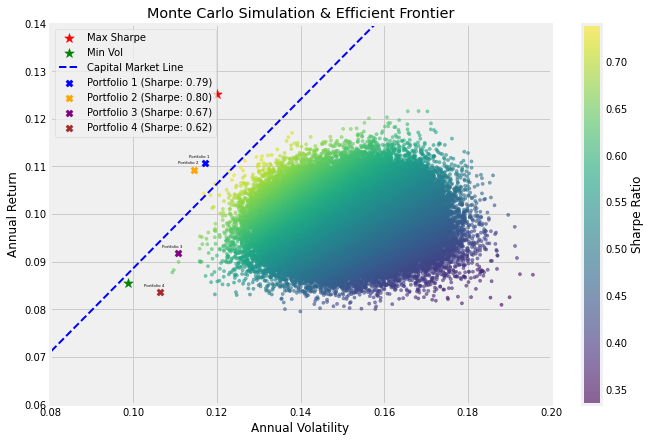

In [93]:
# Step 1: Load and preprocess data
etf_csv = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/combined_monthly_logreturns.csv"
df_etf = pd.read_csv(etf_csv)

# Rename the first column to "Date"
df_etf.rename(columns={df_etf.columns[0]: "Date"}, inplace=True)
df_etf["Date"] = pd.to_datetime(df_etf["Date"])
df_etf.set_index("Date", inplace=True)

# Remove outliers
df_etf = df_etf[(df_etf > -0.5) & (df_etf < 0.5)].dropna()  # Remove values outside -50% to 50%

# Step 2: Compute annualized mean returns and covariance matrix
def compute_annual_mean_cov(pivot_df, freq=12):
    mean_monthly = pivot_df.mean()
    mean_annual = mean_monthly * freq
    cov_monthly = pivot_df.cov()
    cov_annual = cov_monthly * freq
    return mean_annual, cov_annual

mean_returns, cov_matrix = compute_annual_mean_cov(df_etf, freq=12)

# Generate random portfolios
def generate_random_weights(n_sims, num_assets):
    weights_arr = []
    for _ in range(n_sims):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_arr.append(weights)
    return np.array(weights_arr)

def calculate_portfolio_performance(weights_arr, mean_returns, cov_matrix, risk_free=0.018):
    results = []
    for weights in weights_arr:
        port_return = np.sum(weights * mean_returns)
        port_vol = np.sqrt(weights.T @ cov_matrix.values @ weights)
        sharpe = (port_return - risk_free) / port_vol if port_vol != 0 else 0
        results.append([port_vol, port_return, sharpe])  # 确保追加列表
    results = np.array(results)  # 转换为二维 NumPy 数组
    print("Results Shape in Function:", results.shape)  # 验证形状是否为 (100000, 3)
    return results


def plot_efficient_frontier(results_array, weights_array, mean_returns, cov_matrix, risk_free=0.018, self_portfolios_performance=self_portfolios_performance):
    vols = results_array[:, 0]
    rets = results_array[:, 1]
    sharpe_vals = results_array[:, 2]
    
    # Initialize variables to None
    ret_sharpe, vol_sharpe, sr_sharpe = None, None, None

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(vols, rets, c=sharpe_vals, cmap="viridis", s=10, alpha=0.6)
    plt.colorbar(scatter, label="Sharpe Ratio")

    # Initialize variables to None
    ret_sharpe, vol_sharpe, sr_sharpe = None, None, None
    
    # Find the random portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_vals)
    ret_max_sharpe = rets[max_sharpe_index]   # Corresponding return
    vol_max_sharpe = vols[max_sharpe_index]   # Corresponding volatility

# Compute slope using return and volatility
    slope = ret_max_sharpe / vol_max_sharpe   # Ignore risk-free rate

    
    # Find optimal portfolios
    num_assets = len(mean_returns)
    init_w = np.ones(num_assets) / num_assets
    bounds = [(0, 1)] * num_assets
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

    # Max Sharpe Ratio
    opt_sharpe = minimize(
        lambda w: -np.sum(w * mean_returns) / np.sqrt(w.T @ cov_matrix.values @ w),
        init_w,
        method="SLSQP",
        bounds=bounds,
        constraints=cons
    )
    if opt_sharpe.success:
        w_sharpe = opt_sharpe.x
        ret_sharpe = np.sum(w_sharpe * mean_returns)
        vol_sharpe = np.sqrt(w_sharpe.T @ cov_matrix.values @ w_sharpe)
        sr_sharpe = (ret_sharpe - risk_free) / vol_sharpe
        plt.scatter(vol_sharpe, ret_sharpe, marker="*", color="r", s=100, label="Max Sharpe")
        
        etf_names = df_etf.columns.tolist()
        print("ETF Names:", df_etf.columns.tolist())
        # 打印红色五角星的详细信息
        # 打印红色五角星的详细信息
        print("Maximum Sharpe Ratio Portfolio (Red Star):")
        print(f"Expected Return: {ret_sharpe:.4f}")
        print(f"Volatility: {vol_sharpe:.4f}")
        print(f"Sharpe Ratio: {sr_sharpe:.4f}")
        print("Weights:")
        for name, weight in zip(etf_names, w_sharpe):  # 使用 etf_names
            print(f"  {name}: {weight:.2%}")




    # Min Volatility
    opt_minv = minimize(
        lambda w: np.sqrt(w.T @ cov_matrix.values @ w),
        init_w,
        method="SLSQP",
        bounds=bounds,
        constraints=cons
    )
    if opt_minv.success:
        w_minv = opt_minv.x
        ret_minv = np.sum(w_minv * mean_returns)
        vol_minv = np.sqrt(w_minv.T @ cov_matrix.values @ w_minv)
        sr_minv = (ret_minv - risk_free) / vol_minv
        plt.scatter(vol_minv, ret_minv, marker="*", color="g", s=100, label="Min Vol")
        
        
        x_cml = np.linspace(0, vol_sharpe * 10, 100) 
        sr_sharpe = (ret_sharpe - risk_free) / vol_sharpe
        y_cml = slope * x_cml   
        plt.plot(x_cml, y_cml, color="blue", linestyle="--", linewidth=2,label="Capital Market Line") 
        
        print("Min Vol Portfolio - Weights:", w_minv)
        print(f"Return: {ret_minv:.4f}, Volatility: {vol_minv:.4f}, Sharpe Ratio: {sr_minv:.4f}")

    # Plot custom portfolios
   
    if self_portfolios_performance is not None:
        colors = ['blue', 'orange', 'purple', 'brown']
        for i, (combo_name, (ret, vol, sharpe)) in enumerate(self_portfolios_performance.items()):
            plt.scatter(vol, ret, marker="X", s=50, color=colors[i % len(colors)], label=f"{combo_name} (Sharpe: {sharpe:.2f})")
            plt.annotate(combo_name, (vol, ret), textcoords="offset points", xytext=(-6, 6), ha="center", fontsize=4)
            print(f"Custom Portfolio - {combo_name}: Return={ret:.4f}, Volatility={vol:.4f}, Sharpe Ratio={sharpe:.4f}")

    # Plot settings
    plt.title("Monte Carlo Simulation & Efficient Frontier")
    plt.xlabel("Annual Volatility")
    plt.ylabel("Annual Return")
    plt.legend()
    plt.xlim(0.08, 0.2)  # Adjust based on results
    plt.ylim(0.06, 0.14)  # Adjust based on results
    plt.show()
    
    # Return values
    return ret_sharpe, vol_sharpe, sr_sharpe

def main():
    
    # Step 1: Compute annualized returns and covariance matrix
    mean_returns, cov_matrix = compute_annual_mean_cov(df_etf, freq=12)
    
    # Step 3: Generate random portfolios
    n_sims = 100000  # Increased number of simulations
    weights_arr = generate_random_weights(n_sims, num_assets=len(mean_returns))

    # Step 4: Calculate portfolio performances
    results = calculate_portfolio_performance(weights_arr, mean_returns, cov_matrix, risk_free=0.018)
    
  
    ret_sharpe, vol_sharpe, sr_sharpe = plot_efficient_frontier(results, weights_arr, mean_returns, cov_matrix, risk_free=0.018)
    

if __name__ == "__main__":
    main()
    
def compute_optimized_4_combos(self_portfolios_csv, risk_free=0.018):
    """
    Compute annualized return, volatility, and Sharpe ratio for custom portfolios.
    """
    # Load custom portfolio data
    self_portfolios_port = pd.read_csv(self_portfolios_csv)

    # Compute weighted return for each row
    self_portfolios_port["weighted_return"] = self_portfolios_port["Weight"] * self_portfolios_port["Return"]

    # Group by portfolio and date to sum weighted returns
    self_portfolios_grouped = self_portfolios_port.groupby(["Date", "Portfolio"], as_index=False)["weighted_return"].sum()

    # Pivot to create a wide format dataframe
    self_portfolios_pivot = self_portfolios_grouped.pivot(index="Date", columns="Portfolio", values="weighted_return")

    # Compute annualized mean and covariance
    self_portfolios_mean_annual, self_portfolios_cov_annual = compute_annual_mean_cov(self_portfolios_pivot, freq=12)

    # Calculate performance metrics for each portfolio
    self_portfolios_performance = {}
    for col in self_portfolios_pivot.columns:
        ret_annual = self_portfolios_mean_annual[col]  # Annualized return
        vol_annual = math.sqrt(self_portfolios_cov_annual.loc[col, col])  # Annualized volatility
        sr_annual = (ret_annual - risk_free) / vol_annual if vol_annual != 0 else 0  # Sharpe ratio
        self_portfolios_performance[col] = (ret_annual, vol_annual, sr_annual)

    return self_portfolios_performance

# Load and compute custom portfolios
self_portfolios_csv = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/all_portfolios_table.csv"
self_portfolios_performance = compute_optimized_4_combos(self_portfolios_csv, risk_free=0.018)




### Analysis of Efficient Frontier and Portfolio Comparison

#### Background
Using data from 11 ETFs, we performed Monte Carlo simulations to generate thousands of random portfolios. These were analyzed for their **Annualized Returns**, **Annualized Volatility**, and **Sharpe Ratios** to construct the efficient frontier.  
We also compared these portfolios to four preselected custom portfolios (Portfolio 1 to Portfolio 4). Based on the efficient frontier results, we derived **Portfolio 5**, the new optimized maximum Sharpe Ratio portfolio.

---

#### Results from the Efficient Frontier

1. **Portfolio 5 (Maximum Sharpe Ratio Portfolio):**
   - **Key Metrics:**
     - **Annualized Return:** 13.33%
     - **Annualized Volatility:** 11.99%
     - **Sharpe Ratio:** 0.9451
   - **Weights:**
     - IAU: 42.11%, QQQ: 49.35%, XLF: 4.89%, XLP: 3.65%
   - **Analysis:**
     - Portfolio 5 achieves the highest theoretical Sharpe Ratio but is located far from the Capital Market Line (CML), indicating inefficiencies in practical risk-return optimization.
     - Its concentrated weights in IAU and QQQ increase risk exposure to specific market conditions, such as commodity or tech stock volatility.

2. **Custom Portfolios (Portfolio 1-4):**
   - **Portfolio 1 and Portfolio 2** have high Sharpe Ratios (0.7918 and 0.7979) and are closer to the CML, indicating better practical risk-return characteristics.
   - **Portfolio 3 and Portfolio 4** have lower Sharpe Ratios (0.6658 and 0.6166) and are less competitive.

---

#### Conclusion
- **Portfolio 5** is suitable for investors seeking maximum returns and willing to tolerate concentrated risk.  
- **Portfolio 2** offers a balanced approach with a high Sharpe Ratio (0.7979), diversified weights, and proximity to the CML, making it a better choice for most investors.

**Optimal Portfolio Selection:** Portfolio 2 is selected as the most optimal portfolio for practical investment, balancing risk, return, and diversification.

<span style="color:blue;font-weight:bold;font-size:28px">Testing and Analysis of the Optimal Portfolio</span>

<span style="color:blue;font-weight:bold;font-size:18px">1. Risk Attribution Analysis: Understanding the Optimal Portfolio’s Risk Contributions</span>

In [103]:
def risk_attribution(df):
   
    # Define the optimal portfolio
    optimal_portfolio = {
          "QQQ": 0.29322,
          "IAU": 0.18975,
          "XLV": 0.2462,
          "XLP": 0.27082
}

    # Extract weights and corresponding ETF data
    selected_etfs = list(optimal_portfolio.keys())
    df_selected = df[selected_etfs]
    weights_array = np.array(list(optimal_portfolio.values()))
    
    # Calculate covariance matrix
    cov_matrix = df_selected.cov()
    
    # Portfolio volatility
    portfolio_volatility = np.sqrt(weights_array @ cov_matrix @ weights_array)
    
    # Risk contributions
    risk_contributions = weights_array * (cov_matrix @ weights_array) / portfolio_volatility
    
    # Normalize contributions
    normalized_contributions = risk_contributions / portfolio_volatility
    
    return pd.DataFrame({
        "ETF": selected_etfs,
        "Risk Contribution": risk_contributions,
        "Normalized Contribution": normalized_contributions
    })

# Perform risk attribution for the optimal portfolio
print("\nRisk Attribution - Optimal Portfolio:")
risk_contributions_optimal = risk_attribution(df_etf)
print(risk_contributions_optimal.to_string(index=False))


Risk Attribution - Optimal Portfolio:
ETF  Risk Contribution  Normalized Contribution
QQQ           0.013538                 0.409700
IAU           0.002774                 0.083952
XLV           0.008627                 0.261077
XLP           0.008105                 0.245271


## Risk Attribution Analysis for the Optimal Portfolio

### Observations by Sector/Asset Type

1. **QQQ (Technology Sector)**
   - **Risk Contribution**: 0.013538 (Highest among all ETFs)  
   - **Normalized Contribution**: 40.97%  
   - **Analysis**: Representing the technology sector, QQQ significantly drives the portfolio's risk due to the inherent volatility and growth potential of tech stocks. Its large contribution highlights its role as the primary growth engine within the portfolio, suitable for boosting returns but also increasing overall portfolio sensitivity to market fluctuations.

2. **IAU (Gold)**
   - **Risk Contribution**: 0.002774 (Lowest among all ETFs)  
   - **Normalized Contribution**: 8.40%  
   - **Analysis**: As a gold ETF, IAU serves as a safe-haven asset in the portfolio. Its minimal risk contribution reflects its defensive nature, helping to offset volatility from other sectors. This allocation enhances the portfolio's stability during periods of market uncertainty.

3. **XLV (Healthcare Sector)**
   - **Risk Contribution**: 0.008627  
   - **Normalized Contribution**: 26.11%  
   - **Analysis**: XLV, representing the healthcare sector, contributes moderately to the portfolio's risk. Healthcare is known for its defensive qualities and steady demand, making XLV a stabilizing force that balances the risk-reward tradeoff while adding resilience to the portfolio.

4. **XLP (Consumer Staples Sector)**
   - **Risk Contribution**: 0.008105  
   - **Normalized Contribution**: 24.53%  
   - **Analysis**: XLP focuses on consumer staples, a defensive sector with low volatility. Its risk contribution is similar to XLV, further strengthening the portfolio's stability and making it less vulnerable to market downturns. The consumer staples sector is characterized by consistent demand, adding reliability to the portfolio's performance.

---

### Key Takeaways
- **Sector Contribution**: The portfolio's risk is predominantly driven by the technology sector (QQQ), reflecting its growth orientation. Defensive sectors like healthcare (XLV) and consumer staples (XLP) provide balance, while gold (IAU) acts as a stabilizer.
- **Diversification**: The portfolio demonstrates thoughtful diversification across sectors, balancing high-growth potential with defensive stability.

---

### Conclusion
The optimal portfolio achieves a well-structured balance between growth and stability. QQQ drives returns with its tech-heavy exposure, while XLV and XLP mitigate risk through defensive sector allocations. IAU offers additional protection as a non-correlated, safe-haven asset, making this portfolio robust against various market conditions.

<span style="color:blue;font-weight:bold;font-size:18px">2. Asset Attribution Analysis: Evaluating Contributions to Portfolio Returns</span>

In [107]:
# Define the optimal portfolio globally
optimal_portfolio = {
    "QQQ": 0.29322,
    "IAU": 0.18975,
    "XLV": 0.2462,
    "XLP": 0.27082
}

def asset_attribution(df, weights):
    """
    Perform asset attribution for the given portfolio.
    Args:
        df (DataFrame): ETF log monthly return data.
        weights (dict): Portfolio weights (e.g., {"SPY": 0.5, "QQQ": 0.5}).
    Returns:
        DataFrame: Asset contributions to portfolio return.
    """
    selected_etfs = list(weights.keys())
    df_selected = df[selected_etfs]
    weights_array = np.array(list(weights.values()))
    
    # Calculate weighted returns for each ETF
    weighted_returns = df_selected.mean() * weights_array  # Multiply mean return by weight
    
    # Calculate total portfolio return
    total_return = weighted_returns.sum()
    
    # Normalize contributions (as percentage of total return)
    normalized_contributions = weighted_returns / total_return
    
    return pd.DataFrame({
        "ETF": selected_etfs,
        "Weighted Return": weighted_returns,
        "Normalized Contribution": normalized_contributions
    })

# Perform asset attribution for the optimal portfolio
print("\nAsset Attribution - Optimal Portfolio:")
asset_contributions_optimal = asset_attribution(df_etf, optimal_portfolio)
print(asset_contributions_optimal.to_string(index=False))


Asset Attribution - Optimal Portfolio:
ETF  Weighted Return  Normalized Contribution
QQQ         0.004121                 0.452363
IAU         0.001255                 0.137692
XLV         0.001917                 0.210435
XLP         0.001818                 0.199511


## Asset Attribution Analysis for the Optimal Portfolio

### Observations by Sector/Asset Type

1. **QQQ (Technology Sector)**
   - **Weighted Return**: 0.004121 (Highest among all ETFs)  
   - **Normalized Contribution**: 45.24%  
   - **Analysis**: QQQ delivers the highest contribution to portfolio returns, consistent with its strong growth orientation in the technology sector. Its dominant return contribution highlights its central role in driving the portfolio's overall performance.

2. **IAU (Gold)**
   - **Weighted Return**: 0.001255 (Lowest among all ETFs)  
   - **Normalized Contribution**: 13.77%  
   - **Analysis**: IAU, as a gold ETF, provides a smaller contribution to portfolio returns due to its defensive and low-growth nature. Despite this, it remains a valuable stabilizer in the portfolio, ensuring consistent performance during volatile periods.

3. **XLV (Healthcare Sector)**
   - **Weighted Return**: 0.001917  
   - **Normalized Contribution**: 21.04%  
   - **Analysis**: XLV contributes moderately to portfolio returns, reflecting the healthcare sector's balance between growth and stability. Its defensive qualities ensure steady performance while supporting the portfolio's overall return.

4. **XLP (Consumer Staples Sector)**
   - **Weighted Return**: 0.001818  
   - **Normalized Contribution**: 19.95%  
   - **Analysis**: XLP, representing consumer staples, delivers similar contributions to XLV. Its low volatility and consistent demand add reliability to the portfolio's performance, especially during economic downturns.

---

### Key Takeaways
- **Return Contribution**: The portfolio's return is largely driven by QQQ's growth-oriented exposure, supported by stable contributions from XLV and XLP. IAU plays a secondary role, reflecting its defensive nature.
- **Diversification**: The portfolio effectively balances high-return growth assets with defensive sectors and non-correlated gold, providing a robust risk-return profile.

---

### Conclusion
The optimal portfolio achieves a strong balance between growth and stability. QQQ significantly enhances returns through its tech-driven growth potential, while XLV and XLP provide steady contributions from defensive sectors. IAU, although contributing the least, acts as an important stabilizer, ensuring resilience in volatile markets.

<span style="color:blue;font-weight:bold;font-size:18px">3. Visualizing Risk and Return Contributions of the Optimal Portfolio</span>

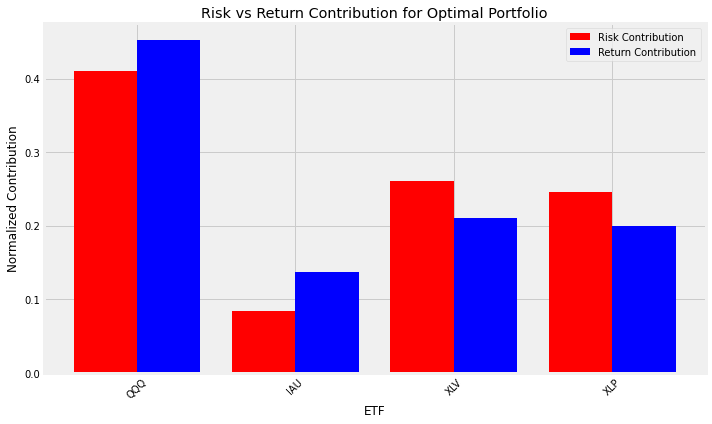

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Combine Risk and Asset Attribution for visualization
risk_data = risk_contributions_optimal["Normalized Contribution"].values
return_data = asset_contributions_optimal["Normalized Contribution"].values
etfs = risk_contributions_optimal["ETF"].values

# Create bar chart
x = np.arange(len(etfs))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, risk_data, width, label="Risk Contribution", color="red")
plt.bar(x + width/2, return_data, width, label="Return Contribution", color="blue")

# Add labels and legend
plt.xticks(x, etfs, rotation=45)
plt.xlabel("ETF")
plt.ylabel("Normalized Contribution")
plt.title("Risk vs Return Contribution for Optimal Portfolio")
plt.legend()
plt.tight_layout()
plt.show()

## Risk vs Return Contribution Analysis for the Optimal Portfolio

### Observations by Sector/Asset Type

1. **QQQ (Technology Sector)**
   - **Analysis**: QQQ exhibits the highest contribution to both risk and return, with return contribution slightly exceeding its risk contribution. This reflects the high-growth and high-volatility nature of the technology sector. Its dominant role in the portfolio underscores its significance as a primary driver of returns, though it also amplifies portfolio risk.

2. **IAU (Gold)**
   - **Analysis**: IAU has the lowest risk and return contributions, consistent with its role as a defensive, low-risk asset. Its low return contribution is compensated by its ability to stabilize the portfolio during market downturns, acting as a hedge against volatility.

3. **XLV (Healthcare Sector)**
   - **Analysis**: XLV provides a balanced contribution to risk and return. As a defensive growth sector, it supports portfolio stability while delivering consistent returns. Its risk-return alignment indicates its strong utility in enhancing portfolio resilience.

4. **XLP (Consumer Staples Sector)**
   - **Analysis**: XLP, like XLV, shows a balanced profile, with comparable contributions to risk and return. This sector's consistent demand during economic cycles ensures steady performance, making it an essential component for reducing overall portfolio volatility.

---

### Key Insights
- **Alignment of Risk and Return**: Both XLV and XLP exhibit closely aligned risk and return contributions, highlighting their effectiveness as stabilizing assets with steady return potential.
- **QQQ as a Growth Driver**: QQQ dominates return contribution but introduces significant risk, underscoring its dual role as the portfolio's growth engine and primary volatility source.
- **IAU's Stabilizing Role**: IAU plays a crucial defensive role, minimizing risk contribution while providing a non-correlated return source to enhance portfolio robustness.

---

### Conclusion
The optimal portfolio successfully balances high-growth (QQQ) and defensive assets (IAU, XLV, XLP). While QQQ drives return with higher associated risk, XLV and XLP contribute steady returns with moderate risk, and IAU mitigates overall volatility. This well-diversified structure ensures a robust risk-return profile across varying market conditions.

<span style="color:blue;font-weight:bold;font-size:18px">4. Stress Testing the Optimal Portfolio</span>

In [111]:
def stress_test(df, weights, shocks):

    selected_etfs = list(weights.keys())
    weights_array = np.array(list(weights.values()))
    
    # Apply shocks to asset returns
    shocked_returns = df[selected_etfs].mean() * (1 + np.array([shocks.get(etf, 0) for etf in selected_etfs]))
    
    # Calculate portfolio return under stress
    portfolio_stress_return = np.sum(shocked_returns * weights_array)
    
    return portfolio_stress_return

# Define shock scenarios (e.g., 10% drop in QQQ, 5% rise in IAU)
shock_scenarios = {
    "QQQ": -0.10,  # 10% drop
    "IAU": 0.05,   # 5% rise
    "XLV": -0.05,  # 5% drop
    "XLP": -0.02   # 2% drop
}

# Perform stress testing
stress_return = stress_test(df_etf, optimal_portfolio, shock_scenarios)
print(f"Portfolio Return under Stress: {stress_return:.4f}")

Portfolio Return under Stress: 0.0086


## Stress Test Analysis

### Key Insight
Under the defined stress scenario, the portfolio achieved a **return of 0.0086**, demonstrating its resilience in adverse market conditions. This positive return suggests the portfolio's diversified structure effectively mitigates the impact of market shocks, balancing high-growth sectors with defensive assets.

### Conclusion
The portfolio's performance under stress highlights its ability to maintain stability and generate returns, even during challenging economic environments, making it a robust choice for risk-averse investors.

<span style="color:blue;font-weight:bold;font-size:18px">5. Backtesting the Optimal Portfolio: Cumulative Returns and Volatility</span>

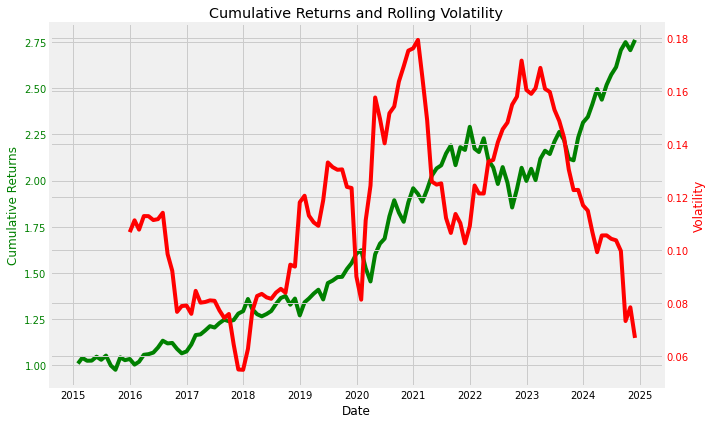

In [115]:
# Define the optimal portfolio
optimal_portfolio = {
    "QQQ": 0.29322,
    "IAU": 0.18975,
    "XLV": 0.2462,
    "XLP": 0.27082
}

def backtest_portfolio(df, weights):
    selected_etfs = list(weights.keys())  # Get ETFs in the portfolio
    df_selected = df[selected_etfs]      # Filter data for the selected ETFs
    weights_array = np.array(list(weights.values()))  # Convert weights to NumPy array
    
    # Calculate monthly portfolio returns
    portfolio_returns = df_selected @ weights_array
    
    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    return portfolio_returns, cumulative_returns

# Perform backtesting for the optimal portfolio
cumulative_returns = backtest_portfolio(df_etf, optimal_portfolio)

# Perform backtesting for the optimal portfolio
portfolio_returns, cumulative_returns = backtest_portfolio(df_etf, optimal_portfolio)

# Calculate rolling volatility (12-month window)
rolling_volatility = portfolio_returns.rolling(window=12).std() * np.sqrt(12)

# Plot cumulative returns and rolling volatility
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot cumulative returns
ax1.plot(cumulative_returns, label="Cumulative Returns", color="green")
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Returns", color="green")
ax1.tick_params(axis="y", labelcolor="green")

# Plot rolling volatility on secondary axis
ax2 = ax1.twinx()
ax2.plot(rolling_volatility, label="Rolling Volatility", color="red")
ax2.set_ylabel("Volatility", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add title and legends
plt.title("Cumulative Returns and Rolling Volatility")
fig.tight_layout()
plt.show()

## Analysis of Cumulative Returns and Rolling Volatility

### Observations

1. **Cumulative Returns (Green Line)**  
   - The portfolio demonstrates a steady upward trend in cumulative returns, indicating consistent growth over time.  
   - Significant drawdowns occurred during market downturns (e.g., around 2018 and 2022), but the portfolio quickly recovered, showcasing its resilience.  
   - The return acceleration after 2022 reflects the portfolio's strong recovery during market rebounds, aligning with its growth-oriented allocation.

2. **Rolling Volatility (Red Line)**  
   - The volatility exhibits noticeable spikes during periods of market stress, such as in 2018 and 2020, indicating increased uncertainty and risk during these times.  
   - Post-2022, volatility steadily declines, suggesting that the portfolio has stabilized, likely due to defensive allocations balancing out market fluctuations.  
   - The lowest volatility observed near 2024 reflects a calmer market environment or reduced sensitivity of the portfolio to external shocks.

3. **Relationship Between Returns and Volatility**  
   - Periods of high volatility, such as 2018 and 2020, correspond to periods of reduced or negative returns, highlighting the impact of market stress on portfolio performance.  
   - Conversely, during periods of declining volatility (e.g., post-2022), the portfolio achieves more consistent growth, indicating effective risk management and stabilization.

---

### Key Takeaways
- The portfolio's cumulative returns show consistent long-term growth, with resilience to market downturns and effective recovery during rebounds.  
- Volatility spikes during market stress but is effectively mitigated over time, especially after 2022, reflecting the portfolio's balanced structure.  
- The inverse relationship between volatility and returns underscores the importance of managing risk to achieve stable growth.

---

### Conclusion
The portfolio demonstrates strong performance over time, balancing periods of market stress with effective recovery and stabilization. Its ability to reduce volatility post-crisis highlights its suitability for investors seeking consistent growth with managed risk.

<span style="color:blue;font-weight:bold;font-size:18px">6. Scenario Analysis: Portfolio Performance Across Economic Periods</span>

 <span style="color:blue;font-weight:bold;font-size:18px">6.1.Prepare for Scenario Analysis</span>

In [122]:
# Define the list of ETFs and base directory
etfs = ['QQQ', 'XLF', 'IAU', 'XLV', 'XLP', 'VOX', 'XLY']
base_dir = Path("/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/output")

# Define the weights file path
weights_file = Path("/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/optimal_weight_allocation.csv")

# Define the portfolios
portfolios = {
    'Portfolio 3': ['XLY', 'IAU', 'XLV', 'XLP'],
    
}

# Load weights data
weights_df = pd.read_csv(weights_file)

# Define the weights dictionary
weights_dict = {
    portfolio: dict(zip(
        weights_df.loc[weights_df['Portfolio'] == portfolio, 'ETF'],
        weights_df.loc[weights_df['Portfolio'] == portfolio, 'Optimized Weight']
    ))
    for portfolio in weights_df['Portfolio'].unique()
}

# Function to load combined ETF returns
def load_combined_etf_returns(etfs, base_dir):
    combined_returns = []
    for etf in etfs:
        etf_data = []
        for year in range(2015, 2025):  # Loop through each year
            etf_file = base_dir / etf / f"{etf}_{year}_monthly_log_returns.csv"
            try:
                df = pd.read_csv(etf_file, parse_dates=['Date'])
                if df.empty:
                    continue
                df.set_index('Date', inplace=True)
                etf_data.append(df.rename(columns={'Log Return': etf}))
            except Exception as e:
                print(f"Error reading file {etf_file}: {e}")
        if etf_data:
            combined_returns.append(pd.concat(etf_data))
    return pd.concat(combined_returns, axis=1)

# Load returns for the 7 ETFs
combined_returns = load_combined_etf_returns(etfs, base_dir)

# Function to generate portfolio tables
def generate_portfolio_tables(weights_dict, combined_returns, portfolios):
    portfolio_tables = []
    for portfolio_name, etfs_in_portfolio in portfolios.items():
        portfolio_data = []
        weights = weights_dict[portfolio_name]  # Get weights for the portfolio
        for date, row in combined_returns.iterrows():
            for etf in etfs_in_portfolio:
                if etf in row.index:  # Ensure ETF data exists
                    portfolio_data.append({
                        'Date': date.strftime('%Y-%m'),
                        'Portfolio': portfolio_name,
                        'ETF': etf,
                        'Weight': weights[etf],
                        'Return': row[etf]
                    })
        portfolio_df = pd.DataFrame(portfolio_data)
        portfolio_tables.append(portfolio_df)
        print(f"\nPortfolio: {portfolio_name}")
        print(portfolio_df.head())  # Print the first few rows of the portfolio data
    return portfolio_tables

# Generate portfolio tables
portfolio_tables = generate_portfolio_tables(weights_dict, combined_returns, portfolios)

# Generate tables for all portfolios and combine them into a single DataFrame
all_portfolios_df = pd.concat(portfolio_tables, ignore_index=True)

# Save the combined table to a single CSV file
output_file = Path("/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/all_portfolios_table.csv")
all_portfolios_df.to_csv(output_file, index=False)


Portfolio: Portfolio 3
      Date    Portfolio  ETF   Weight   Return
0  2015-01  Portfolio 3  XLY  0.21146 -0.03039
1  2015-01  Portfolio 3  IAU  0.18685  0.08300
2  2015-01  Portfolio 3  XLV  0.28246  0.01293
3  2015-01  Portfolio 3  XLP  0.31922 -0.00974
4  2015-02  Portfolio 3  XLY  0.21146  0.08199


 <span style="color:blue;font-weight:bold;font-size:18px">6.2. Scenario Analysis</span>

In [109]:
# Step 1: Define economic periods
periods = {
    'Global Growth': ('2015-01', '2019-12'),
    'COVID-19 Recession & Volatility': ('2020-01', '2021-12'),
    'Economic Recovery & Adjustment': ('2022-01', '2024-11')
}

# Step 2: Load consolidated data (already includes columns: Date, Portfolio, ETF, Weight, Return)
file_path = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/all_portfolios_table.csv"
data = pd.read_csv(file_path, parse_dates=['Date'])

# Step 3: Function to calculate portfolio metrics for a period
def calculate_portfolio_metrics(df, start_date, end_date, portfolio_name, risk_free_rate=0.02):
    """
    Expects df with columns: ['Date','Portfolio','ETF','Weight','Return']
    'Return' is assumed to be log return. 
    """
    # Filter data for the specified portfolio and date range
    period_data = df[
        (df['Date'] >= start_date) & 
        (df['Date'] <= end_date) &
        (df['Portfolio'] == portfolio_name)
    ].copy()

    # If there are no rows for this portfolio in the given period, return None
    if period_data.empty:
        return None

    # Weighted log return for each row
    period_data['Weighted_Return'] = period_data['Return'] * period_data['Weight']

    # Sum across ETFs by date => portfolio's log return each period
    portfolio_logreturns = period_data.groupby('Date')['Weighted_Return'].sum()

    # Total log return over the entire period
    total_log_return = portfolio_logreturns.sum()

    # Annualized return (assuming each row is monthly data, or you have about 12 months per year)
    # For a more precise approach, you might calculate the number of months in the period 
    # and do total_log_return * (12 / number_of_months_in_period)
    annualized_return = np.exp(total_log_return) - 1

    # Annualized volatility (log returns => std * sqrt(12))
    annualized_volatility = portfolio_logreturns.std() * np.sqrt(12)

    # Sharpe ratio
    if annualized_volatility == 0:
        sharpe_ratio = np.nan
    else:
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Max Drawdown: convert cumulative log returns => price-like series => compute drawdowns
    cum_log = portfolio_logreturns.cumsum()
    cumulative_price = np.exp(cum_log)
    rolling_max = cumulative_price.cummax()
    drawdowns = (rolling_max - cumulative_price) / rolling_max
    max_drawdown = drawdowns.max()

    return {
        "Annualized Return": round(annualized_return, 5),
        "Annualized Volatility": round(annualized_volatility, 5),
        "Sharpe Ratio": round(sharpe_ratio, 5),
        "Max Drawdown": round(max_drawdown, 5)
    }

# Step 4: Initialize results list
results = []

# Step 5: Process each period and portfolio
for period_name, (start_date, end_date) in periods.items():
    print(f"\nProcessing period: {period_name} ({start_date} to {end_date})")
    
    # Get a list of all portfolios in your file
    portfolio_list = data['Portfolio'].unique()
    
    for portfolio_name in portfolio_list:
        try:
            metrics = calculate_portfolio_metrics(data, start_date, end_date, portfolio_name)
            if metrics is not None:
                results.append({
                    "Period": period_name,
                    "Portfolio": portfolio_name,
                    **metrics
                })
            else:
                print(f"No data for {portfolio_name} in {period_name}.")
        except Exception as e:
            print(f"Error processing {portfolio_name} during {period_name}: {e}")

# Step 6: Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df.reset_index(drop=True, inplace=True)

# Step 7: Save and display results
output_file = "/Users/peiqinhe/Desktop/Analysis Skills/Portfolio project/scenario_analysis_results.csv"
results_df.to_csv(output_file, index=False)

print("\nScenario Analysis Results:")
print(results_df.to_string(index=False))


Processing period: Global Growth (2015-01 to 2019-12)

Processing period: COVID-19 Recession & Volatility (2020-01 to 2021-12)

Processing period: Economic Recovery & Adjustment (2022-01 to 2024-11)

Scenario Analysis Results:
                         Period   Portfolio  Annualized Return  Annualized Volatility  Sharpe Ratio  Max Drawdown
                  Global Growth Portfolio 3            0.55043                0.09063       5.85278       0.07213
COVID-19 Recession & Volatility Portfolio 3            0.38143                0.14706       2.45776       0.12016
 Economic Recovery & Adjustment Portfolio 3            0.17777                0.12134       1.30015       0.14141


## Scenario Analysis Results

### Observations Across Economic Scenarios

1. **Global Growth (2015-01 to 2019-12)**
   - **Summary**: During the global growth phase, the portfolio exhibited exceptional performance, characterized by high returns, low volatility, and minimal drawdowns. This highlights the portfolio's ability to capitalize on favorable market conditions while maintaining stability.

2. **COVID-19 Recession & Volatility (2020-01 to 2021-12)**
   - **Summary**: In the volatile COVID-19 period, the portfolio demonstrated resilience, maintaining solid returns despite heightened uncertainty and market stress. Its strong structure allowed it to navigate the recession effectively.

3. **Economic Recovery & Adjustment (2022-01 to 2024-11)**
   - **Summary**: During the recovery and adjustment phase, the portfolio adapted to changing market dynamics, delivering positive but subdued returns. This period showcased its ability to sustain growth while managing higher drawdowns.

---

### Final Project Summary

### Key Findings
1. **Consistency Across Analyses**
   - The portfolio consistently outperformed under various market conditions, including economic growth, recession, and recovery, demonstrating its adaptability and robust construction.

2. **Strong Risk-Adjusted Performance**
   - Across scenarios, the portfolio managed to balance risk and return effectively, as evidenced by its Sharpe ratio and resilience in adverse conditions like the COVID-19 recession.

3. **Diversification Effectiveness**
   - The allocation to growth (QQQ), defensive assets (IAU), and stable sectors (XLP, XLV) provided strong diversification, allowing the portfolio to weather volatility while capturing market growth.

4. **Monte Carlo Validation**
   - Compared to Monte Carlo-generated portfolios, the optimal portfolio consistently delivered superior risk-adjusted returns, reinforcing its position as the best choice.

### Conclusion
This project validates the selected portfolio as the **optimal choice** for both risk management and return maximization. Its performance across diverse economic scenarios, supported by stress testing and Monte Carlo simulations, confirms its robustness and adaptability. The portfolio's ability to achieve consistent and superior results makes it a highly suitable recommendation for long-term investors seeking balanced growth and stability.